# Pump it Up: Data Mining the Water Table

## Introduction

This project aims to utilize machine learning and data visualization to predict the operating condition of a waterpoint for each record in the dataset, and to identify potential issues with existing water well projects, in order to promote access to clean, potable water across Tanzania.

## Business Understanding

While recognizing Tanzania's recent efforts to enhance clean water accessibility, the UN-Habitat acknowledges that a significant portion of the population still lacks safe water access. To address this, an initiative is being proposed to evaluate the distribution of wells in Tanzania and assess the functionality of water pumps in existing wells. The wells in Tanzania can be categorized as functional, non-functional, or in need of repair.



## Objectives

**Primary Objective:**

To deliver accurate predictions regarding the operational status of wells.

**Specific Objectives:**
- Identify installers resulting in the most nonfunctional waterpoint pumps.
- Determine how extraction type influences operational status of a water pump
- Identify where most non-functional water pumps are located in Tanzania.
- Identify the proportions of functional, non-functional and pumps in need of repair

## 1. Data Understanding

The target variable in this dataset is **status_group** with the following labels:

- **functional** - the waterpoint is operational and there are no repairs needed
- **functional needs repair** - the waterpoint is operational, but needs repairs
- **non functional** - the waterpoint is not operational

### Data Source

The dataset for this analysis can be downloaded from [Driven Data Website](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/.)
The data comprised 4 CSV files:

    1. Training set values.csv
    2. Test set values.csv
    3. Training set labels.csv
    4. Submission format.csv
The train dataset has 59400 datapoints and 40 features

The following set of information was provided about the waterpoints:

- amount_tsh - Total static head (amount water available to waterpoint)
- date_recorded - The date the row was entered
- funder - Who funded the well
- gps_height - Altitude of the well
- installer - Organization that installed the well
- longitude - GPS coordinate
- latitude - GPS coordinate
- wpt_name - Name of the waterpoint if there is one
- basin - Geographic water basin
- subvillage - Geographic location
- region - Geographic location
- region_code - Geographic location (coded)
- district_code - Geographic location (coded)
- lga - Geographic location
- ward - Geographic location
- population - Population around the well
- public_meeting - True/False
- recorded_by - Group entering this row of data
- scheme_management - Who operates the waterpoint
- scheme_name - Who operates the waterpoint
- permit - If the waterpoint is permitted
- construction_year - Year the waterpoint was constructed
- extraction_type - The kind of extraction the waterpoint uses
- extraction_type_group - The kind of extraction the waterpoint uses
- extraction_type_class - The kind of extraction the waterpoint uses
- management - How the waterpoint is managed
- management_group - How the waterpoint is managed
- payment - What the water costs
- payment_type - What the water costs
- water_quality - The quality of the water
- quality_group - The quality of the water
- quantity - The quantity of water
- quantity_group - The quantity of water
- source - The source of the water
- source_type - The source of the water
- source_class - The source of the water
- waterpoint_type - The kind of waterpoint
- waterpoint_type_group - The kind of waterpoint

### Importing libraries

In [1]:
# Data Manipulation and Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Model Evaluation Metrics
from sklearn.metrics import (
    precision_score, recall_score, log_loss, ConfusionMatrixDisplay,
    accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix,
    classification_report
)

# Feature Engineering and data preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Model Pipelines
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImPipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# Maps visualization

import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")


In [2]:
# Import all the well data
X_df = pd.read_csv('../Data/training_set_values.csv', index_col='id')
y_df = pd.read_csv('../Data/training_set_labels.csv', index_col='id')

X_submission = pd.read_csv('../Data/test_set_values.csv')

In [3]:
# Merge target columns df and features df in order to change target values into numerical object
train_df = pd.merge(y_df, X_df, how='inner', on='id')
train_df.head()

,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
id,,,,,,,,,,,,,,,,,,,,,
69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


In [4]:
# Change target values to numeric values
train_df['status'] = train_df.status_group.map({"non functional":0, "functional needs repair":1, "functional":2})

### Data Properties

In [5]:
train_df.shape

(59400, 41)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 59400 entries, 69572 to 26348
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   status_group           59400 non-null  object 
 1   amount_tsh             59400 non-null  float64
 2   date_recorded          59400 non-null  object 
 3   funder                 55763 non-null  object 
 4   gps_height             59400 non-null  int64  
 5   installer              55745 non-null  object 
 6   longitude              59400 non-null  float64
 7   latitude               59400 non-null  float64
 8   wpt_name               59398 non-null  object 
 9   num_private            59400 non-null  int64  
 10  basin                  59400 non-null  object 
 11  subvillage             59029 non-null  object 
 12  region                 59400 non-null  object 
 13  region_code            59400 non-null  int64  
 14  district_code          59400 non-null  int64  
 15  lga

In [7]:
# summary of numeric columns
train_df.describe()

,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year,status
count,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475,1.158838
std,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547,0.949794
min,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000
50%,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000,2.000000
75%,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000,2.000000
max,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000,2.000000


## 2. Data Preparation

### 2.1 Data Cleaning

In [8]:
# Checking for Nan and null values in our dataset
train_df.isna().sum()

status_group                 0
amount_tsh                   0
date_recorded                0
funder                    3637
gps_height                   0
installer                 3655
longitude                    0
latitude                     0
wpt_name                     2
num_private                  0
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code                0
lga                          0
ward                         0
population                   0
public_meeting            3334
recorded_by                  0
scheme_management         3878
scheme_name              28810
permit                    3056
construction_year            0
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_

We can see that there are columns with lots of null values, while also having some columns duplicating already existing columns but with different column names.

In [9]:
#checking for unique values
dict = {}
dfp = train_df.copy().drop(['status_group', 'status'], axis =1)
# Seeing how many unique values are in each features 
for x in dfp.columns:
    if dfp[x].dtypes == 'object':
        dict[x] = len(dfp[x].value_counts())
dict

{'date_recorded': 356,
 'funder': 1896,
 'installer': 2145,
 'wpt_name': 37399,
 'basin': 9,
 'subvillage': 19287,
 'region': 21,
 'lga': 125,
 'ward': 2092,
 'public_meeting': 2,
 'recorded_by': 1,
 'scheme_management': 11,
 'scheme_name': 2695,
 'permit': 2,
 'extraction_type': 18,
 'extraction_type_group': 13,
 'extraction_type_class': 7,
 'management': 12,
 'management_group': 5,
 'payment': 7,
 'payment_type': 7,
 'water_quality': 8,
 'quality_group': 6,
 'quantity': 5,
 'quantity_group': 5,
 'source': 10,
 'source_type': 7,
 'source_class': 3,
 'waterpoint_type': 7,
 'waterpoint_type_group': 6}

In [10]:
#function to get value counts
def get_value_counts(column):
    return train_df[column].value_counts()

In [11]:
# checking for unique values in the target column and their count
get_value_counts('status_group')

status_group
functional                 32259
non functional             22824
functional needs repair     4317
Name: count, dtype: int64

The target values have high class imbalance. 

### 2.1.1 Data Wrangling 

#### quantity / quantity_group columns

In [12]:
# checking for unique values
get_value_counts('quantity')

quantity
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: count, dtype: int64

In [13]:
# checking for unique values
get_value_counts('quantity_group')

quantity_group
enough          33186
insufficient    15129
dry              6246
seasonal         4050
unknown           789
Name: count, dtype: int64

Checking the two columns, we see that they have exactly similar values. We can remove one column ('quantity') to reduce duplication.

Creating a function to give the count plot:

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_countplot(df, x_col, hue_col='status_group', fig_size=(13,7)):
    """
    Parameters:
    - df: DataFrame, the input dataframe
    - x_col: str, the column to be plotted on the x-axis
    - hue_col: str, the column to be used for color differentiation
    - fig_size: tuple, optional, the size of the figure (width, height)

    Returns:
    - None (displays the plot)
    """
    # Set the figure size
    plt.figure(figsize=fig_size)

    # Create the countplot
    ax = sns.countplot(x=x_col, hue=hue_col, data=train_df)
    # title
    ax.set_title(f'Countplot of {x_col} with Hue {hue_col}')

    # Show the plot
    plt.show()

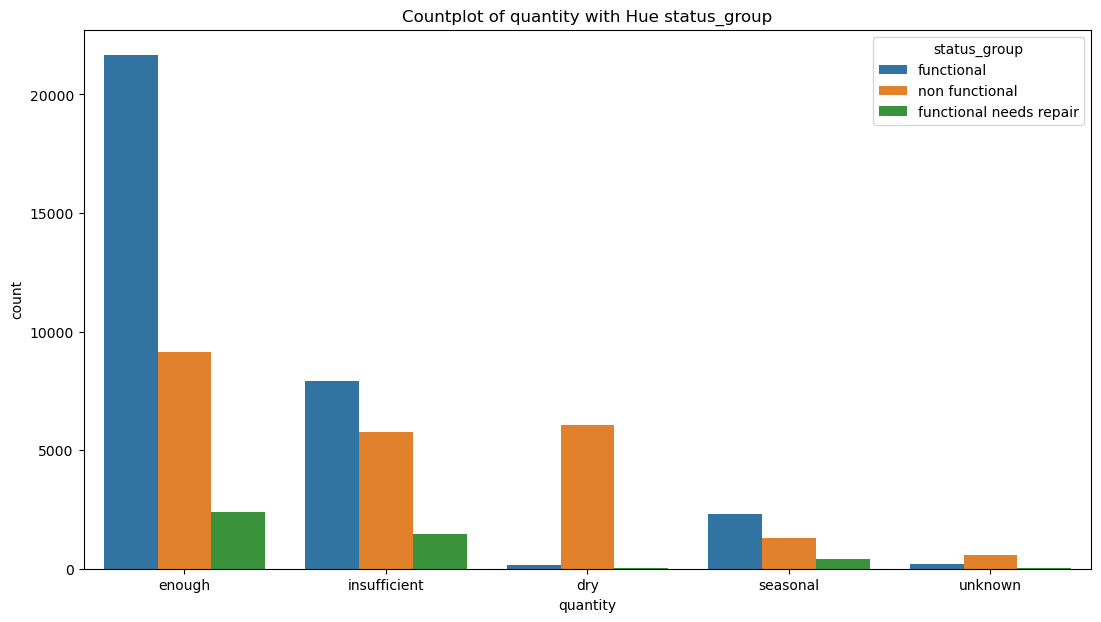

In [15]:
plot_countplot(train_df, x_col='quantity')

From the plot above, we can see that there are wells with 'enough' water but non-functional. We can also get a picture that in 'dry' quantity, most wells are non-functional. This is to mean that if a well is dry, then you can be almost certain that it is non-functional, and if there is enough water in the well, then there's higher chances that it is functional.

This implies a relationship between the quantity of water and the functionality of the wells, suggesting that the availability of water is a key factor influencing whether a well is functional or non-functional

#### scheme_management / management / management_group columns

In [16]:
# checking for unique values
get_value_counts('scheme_management')

scheme_management
VWC                 36793
WUG                  5206
Water authority      3153
WUA                  2883
Water Board          2748
Parastatal           1680
Private operator     1063
Company              1061
Other                 766
SWC                    97
Trust                  72
Name: count, dtype: int64

In [17]:
# checking for unique values
get_value_counts('management')

management
vwc                 40507
wug                  6515
water board          2933
wua                  2535
private operator     1971
parastatal           1768
water authority       904
other                 844
company               685
unknown               561
other - school         99
trust                  78
Name: count, dtype: int64

The above two columns, 'management' and 'scheme_management', have almost the same information. We will drop 'scheme_management'.

In [18]:
# checking for unique values
get_value_counts('management_group')

management_group
user-group    52490
commercial     3638
parastatal     1768
other           943
unknown         561
Name: count, dtype: int64

In [19]:
# accessing specific values in the above column
train_df.loc[train_df['management_group']=='user-group']['management'].value_counts() ,train_df.loc[train_df['management_group']=='commercial']['management'].value_counts() 

(management
 vwc            40507
 wug             6515
 water board     2933
 wua             2535
 Name: count, dtype: int64,
 management
 private operator    1971
 water authority      904
 company              685
 trust                 78
 Name: count, dtype: int64)

To find the subgroups of 'management_group' column, we checked the 'user-group' values and saw that this column is just the grouped version of 'management'. Although 'management' has more detailed values, we decided to drop 'management_group' column.

Grouping the dataframe by 'management_group'and 'management' we see that:

In [20]:
# checking for subgroups of commercial, other, parastartal and user group
train_df.groupby(['management_group','management']).count()

status_group  amount_tsh  date_recorded  \
management_group management                                                  
commercial       company                    685         685            685   
                 private operator          1971        1971           1971   
                 trust                       78          78             78   
                 water authority            904         904            904   
other            other                      844         844            844   
                 other - school              99          99             99   
parastatal       parastatal                1768        1768           1768   
unknown          unknown                    561         561            561   
user-group       vwc                      40507       40507          40507   
                 water board               2933        2933           2933   
                 wua                       2535        2535           2535   
                 wug                       6515        6515           6515   

                                   funder  gps_height  installer  longitude  \
management_group management                                                   
commercial       company              663         685        663        685   
                 private operator    1957        1971       1959       1971   
                 trust                 78          78         78         78   
                 water authority      836         904        836        904   
other            other                837         844        831        844   
                 other - school        99          99         99         99   
parastatal       parastatal          1624        1768       1626       1768   
unknown          unknown              533         561        527        561   
user-group       vwc                37630       40507      37630      40507   
                 water board         2715        2933       2714       2933   
                 wua                 2308        2535       2309       2535   
                 wug                 6483        6515       6473       6515   

                                   latitude  wpt_name  num_private  ...  \
management_group management                                         ...   
commercial       company                685       685          685  ...   
                 private operator      1971      1971         1971  ...   
                 trust                   78        78           78  ...   
                 water authority        904       904          904  ...   
other            other                  844       844          844  ...   
                 other - school          99        99           99  ...   
parastatal       parastatal            1768      1768         1768  ...   
unknown          unknown                561       561          561  ...   
user-group       vwc                  40507     40507        40507  ...   
                 water board           2933      2932         2933  ...   
                 wua                   2535      2535         2535  ...   
                 wug                   6515      6514         6515  ...   

                                   water_quality  quality_group  quantity  \
management_group management                                                 
commercial       company                     685            685       685   
                 private operator           1971           1971      1971   
                 trust                        78             78        78   
                 water authority             904            904       904   
other            other                       844            844       844   
                 other - school               99             99        99   
parastatal       parastatal                 1768           1768      1768   
unknown          unknown                     561            561       561   
user-group    

#### source / source_type / source_class columns

In [21]:
# checking for unique values
get_value_counts('source')

source
spring                  17021
shallow well            16824
machine dbh             11075
river                    9612
rainwater harvesting     2295
hand dtw                  874
lake                      765
dam                       656
other                     212
unknown                    66
Name: count, dtype: int64

In [22]:
# checking for unique values
get_value_counts('source_type')

source_type
spring                  17021
shallow well            16824
borehole                11949
river/lake              10377
rainwater harvesting     2295
dam                       656
other                     278
Name: count, dtype: int64

In [23]:
# checking for unique values
get_value_counts('source_class')

source_class
groundwater    45794
surface        13328
unknown          278
Name: count, dtype: int64

We can see that the above columns have duplicate information, so we retain only 'source' column.

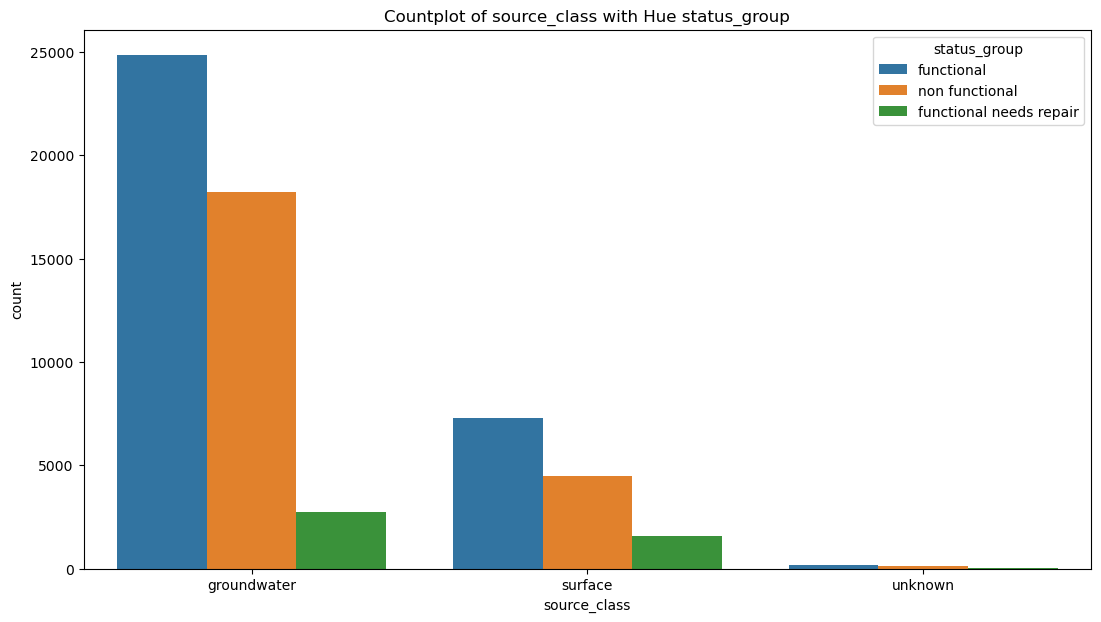

In [24]:
plot_countplot(train_df, x_col='source_class')

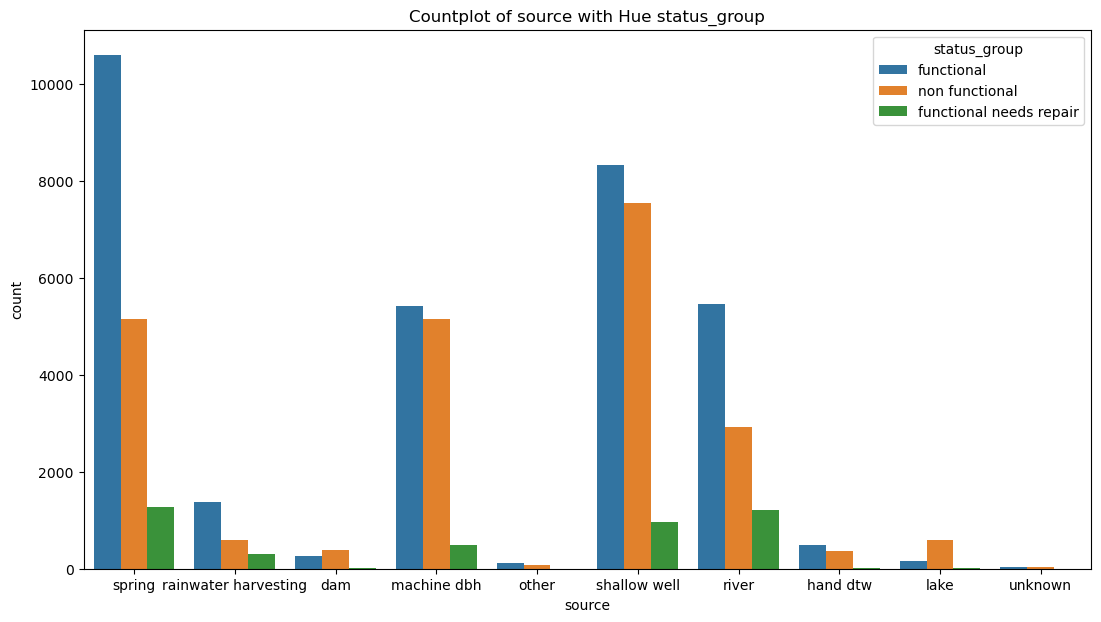

In [25]:
plot_countplot(train_df, x_col='source')

Its quite evident that most wells are functional when plotted against the source.

#### payment / payment_type columns

In [26]:
# checking for unique values
get_value_counts('payment')

payment
never pay                25348
pay per bucket            8985
pay monthly               8300
unknown                   8157
pay when scheme fails     3914
pay annually              3642
other                     1054
Name: count, dtype: int64

In [27]:
# checking for unique values
get_value_counts('payment_type')

payment_type
never pay     25348
per bucket     8985
monthly        8300
unknown        8157
on failure     3914
annually       3642
other          1054
Name: count, dtype: int64

The two columns are also similar so we drop one.

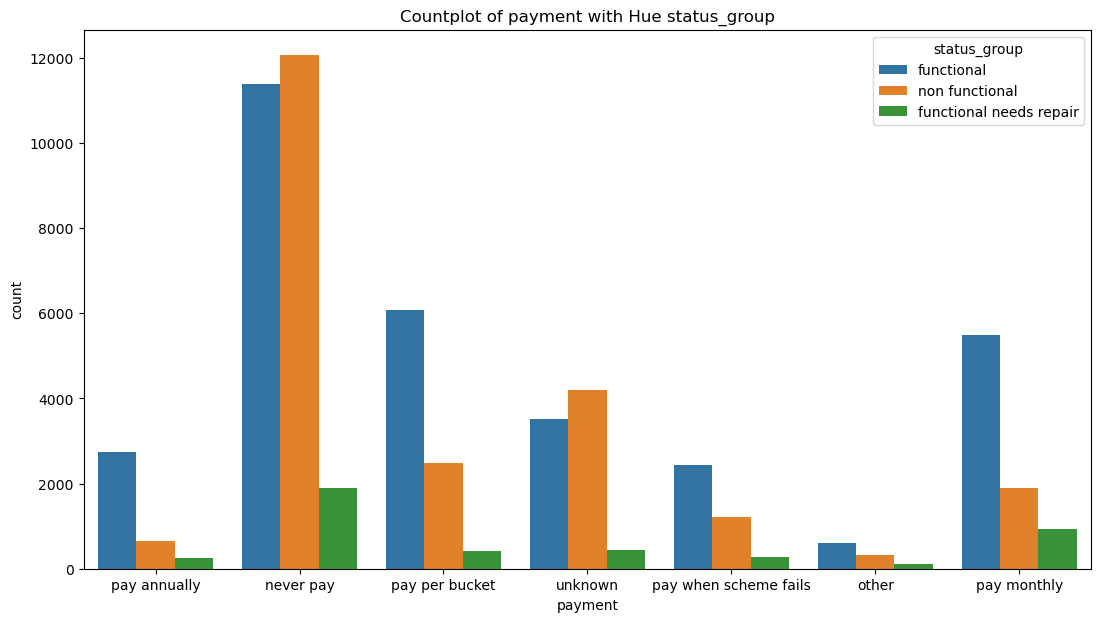

In [28]:
plot_countplot(train_df, x_col='payment')

We can clearly see that where payment is made, there is a higher count of functional wells to non-functional. Whereas in cases where payment isn't made or we have unknown payment, we see that there is a high number of non-functional wells.

This suggests that there is a relationship between payment and the functionality of wells. It could be that payment is associated with better maintenance or higher-quality wells, leading to increased functionality. 

#### extraction_type / extraction_type_group / extraction_type_class columns

In [29]:
# checking for unique values
get_value_counts('extraction_type')

extraction_type
gravity                      26780
nira/tanira                   8154
other                         6430
submersible                   4764
swn 80                        3670
mono                          2865
india mark ii                 2400
afridev                       1770
ksb                           1415
other - rope pump              451
other - swn 81                 229
windmill                       117
india mark iii                  98
cemo                            90
other - play pump               85
walimi                          48
climax                          32
other - mkulima/shinyanga        2
Name: count, dtype: int64

In [30]:
# checking for unique values
get_value_counts('extraction_type_group')

extraction_type_group
gravity            26780
nira/tanira         8154
other               6430
submersible         6179
swn 80              3670
mono                2865
india mark ii       2400
afridev             1770
rope pump            451
other handpump       364
other motorpump      122
wind-powered         117
india mark iii        98
Name: count, dtype: int64

In [31]:
# checking for unique values
get_value_counts('extraction_type_class')

extraction_type_class
gravity         26780
handpump        16456
other            6430
submersible      6179
motorpump        2987
rope pump         451
wind-powered      117
Name: count, dtype: int64

In [32]:
# to see sub-groups in extraction_type_clas based on extraction_type_group
train_df.groupby(['extraction_type_class', 'extraction_type_group']).count()

status_group  amount_tsh  \
extraction_type_class extraction_type_group                             
gravity               gravity                       26780       26780   
handpump              afridev                        1770        1770   
                      india mark ii                  2400        2400   
                      india mark iii                   98          98   
                      nira/tanira                    8154        8154   
                      other handpump                  364         364   
                      swn 80                         3670        3670   
motorpump             mono                           2865        2865   
                      other motorpump                 122         122   
other                 other                          6430        6430   
rope pump             rope pump                       451         451   
submersible           submersible                    6179        6179   
wind-powered          wind-powered                    117         117   

                                             date_recorded  funder  \
extraction_type_class extraction_type_group                          
gravity               gravity                        26780   24704   
handpump              afridev                         1770    1668   
                      india mark ii                   2400    2358   
                      india mark iii                    98      98   
                      nira/tanira                     8154    7899   
                      other handpump                   364     353   
                      swn 80                          3670    3595   
motorpump             mono                            2865    2577   
                      other motorpump                  122     122   
other                 other                           6430    6010   
rope pump             rope pump                        451     448   
submersible           submersible                     6179    5819   
wind-powered          wind-powered                     117     112   

                                             gps_height  installer  longitude  \
extraction_type_class extraction_type_group                                     
gravity               gravity                     26780      24714      26780   
handpump              afridev                      1770       1665       1770   
                      india mark ii                2400       2358       2400   
                      india mark iii                 98         98         98   
                      nira/tanira                  8154       7885       8154   
                      other handpump                364        354        364   
                      swn 80                       3670       3593       3670   
motorpump             mono                         2865       2578       2865   
                      other motorpump               122        122        122   
other                 other                        6430       6002       6430   
rope pump             rope pump                     451        448        451   
submersible           submersible                  6179       5816       6179   
wind-powered          wind-powered                  117        112        117   

                                             latitude  wpt_name  num_private  \
extraction_type_class extraction_type_group                                    
gravity               gravity                   26780     26779        26780   
handpump              afridev                    1770      1770         1770   
                      india mark ii              2400      2400         2400   
                      india mark iii               98        98           98   
                      nira/tanira                8154      8154         8154   
                      other handpump              364       364          364   
                      swn 80              

We keep 'extraction_type_group' and drop the rest to reduce duplicate values.

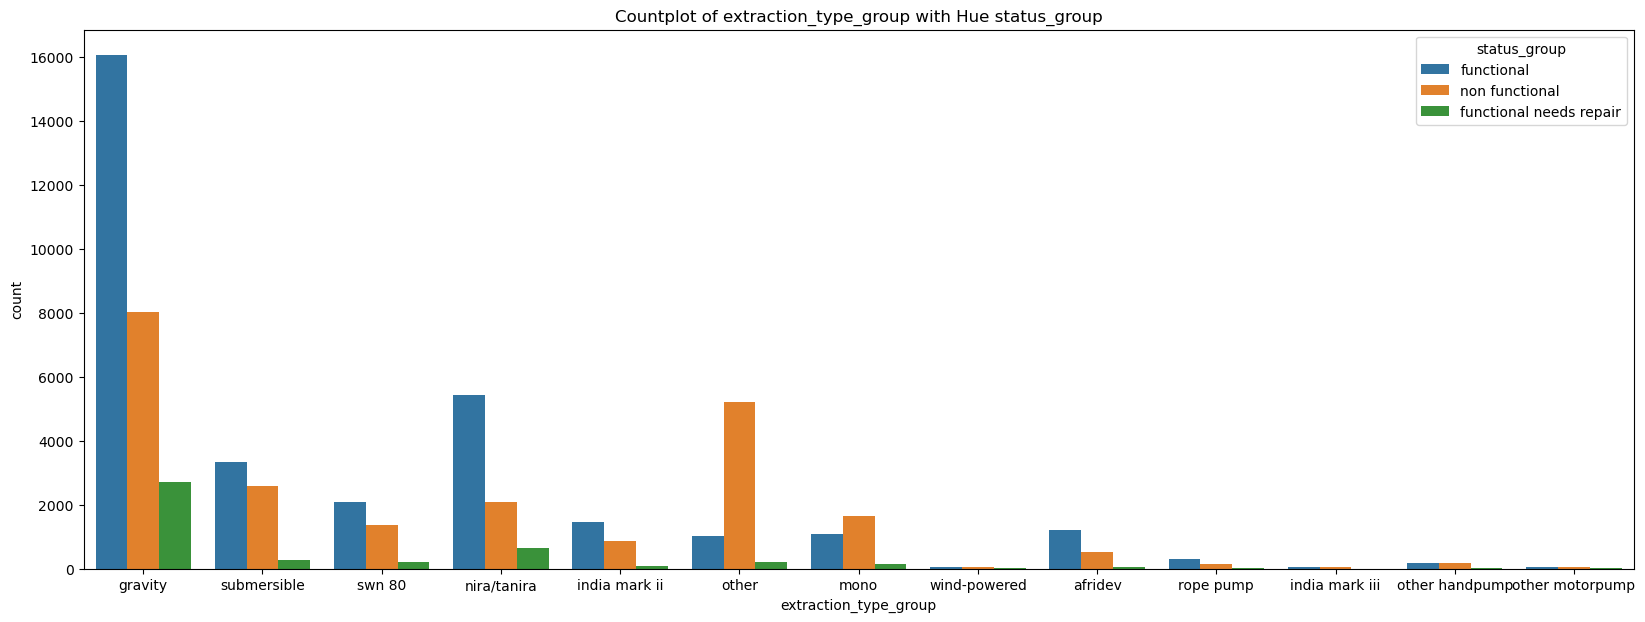

In [33]:
plot_countplot(train_df, x_col='extraction_type_group',fig_size=(20,7))

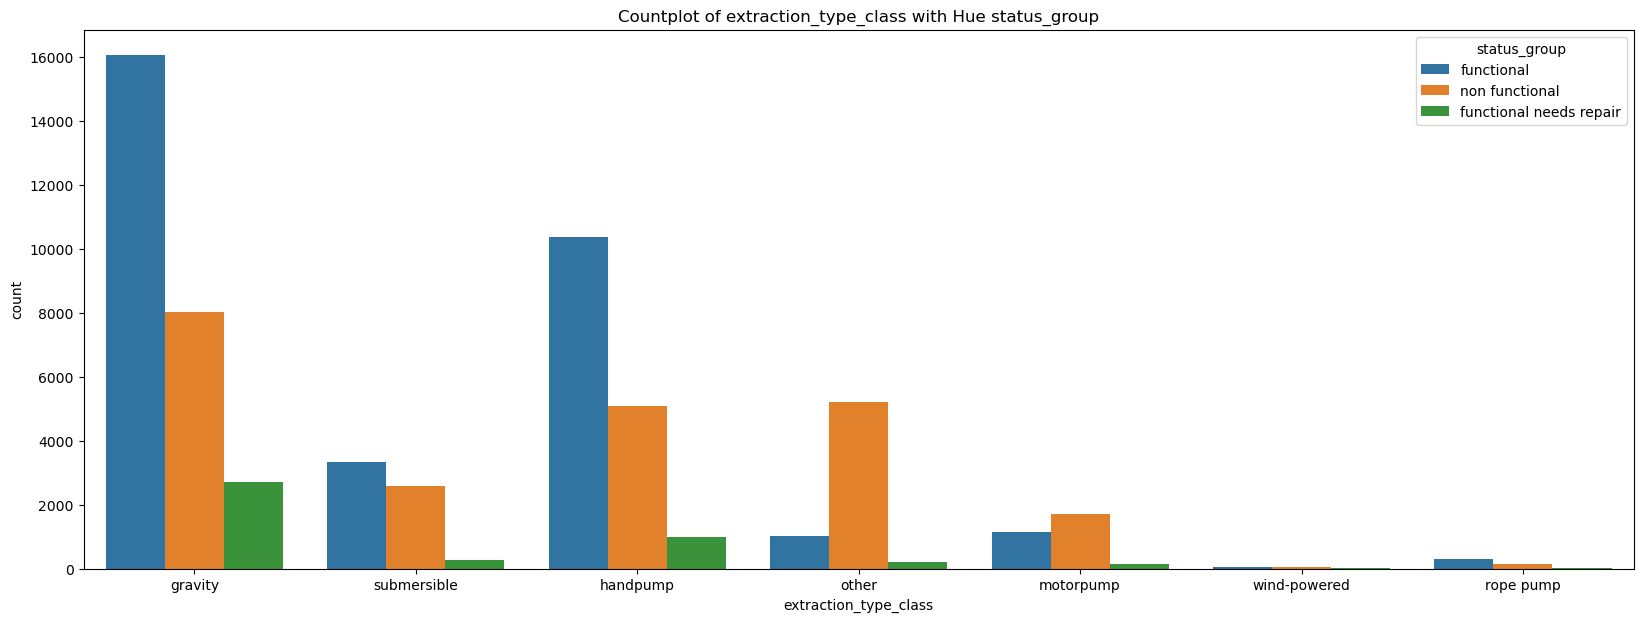

In [34]:
plot_countplot(train_df, x_col='extraction_type_class',fig_size=(20,7))

In almost all the major extraction types(gravity, submersible and handpump), we have more functional wells.

There is a consistent trend of having more functional wells, meaning, functionality does not seem to vary significantly with the extraction type. instead, the prevalence of functional wells appears to be a common characteristic across these extraction methods, save for 'motorpump' and 'other'.

#### waterpoint_type / waterpoint_type_group

In [35]:
# checking for unique values
get_value_counts('waterpoint_type')

waterpoint_type
communal standpipe             28522
hand pump                      17488
other                           6380
communal standpipe multiple     6103
improved spring                  784
cattle trough                    116
dam                                7
Name: count, dtype: int64

In [36]:
# checking for unique values
get_value_counts('waterpoint_type_group')

waterpoint_type_group
communal standpipe    34625
hand pump             17488
other                  6380
improved spring         784
cattle trough           116
dam                       7
Name: count, dtype: int64

We will keep 'waterpoint_type' which contains more detail.

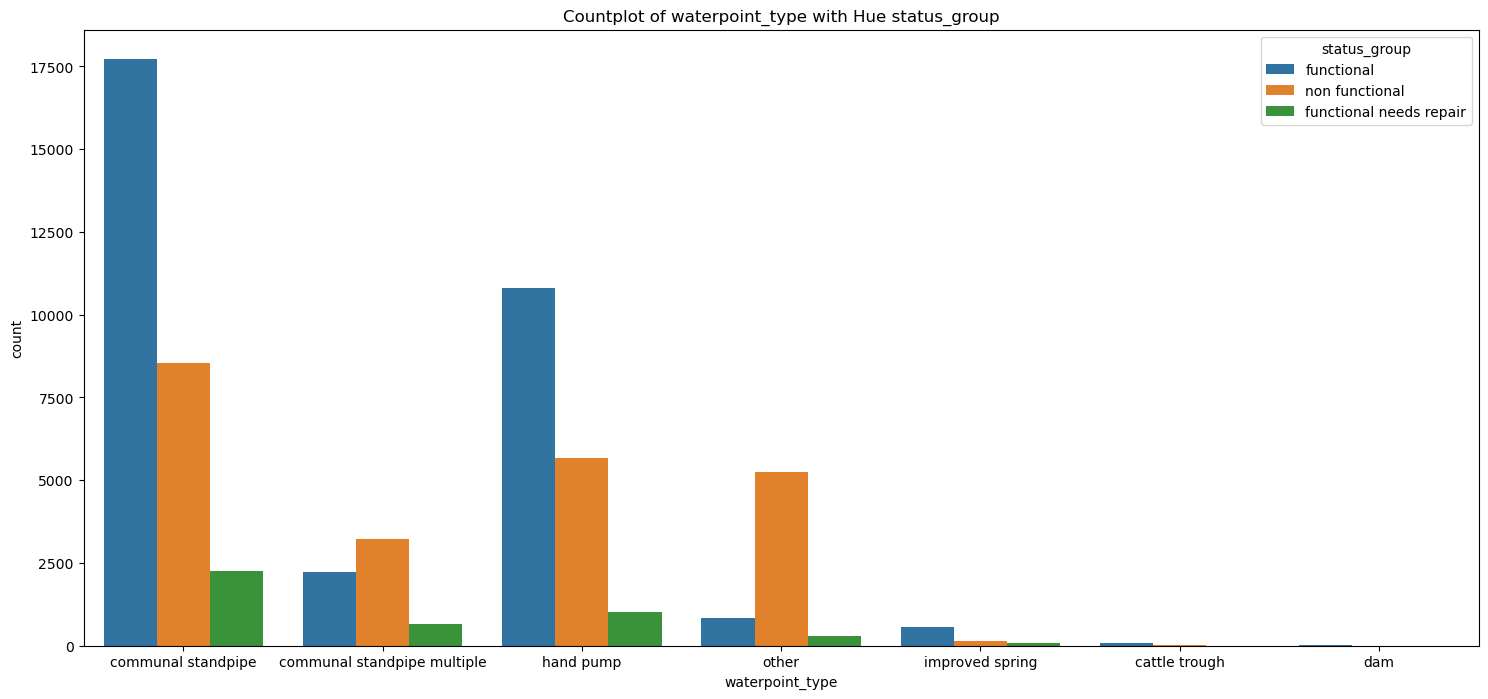

In [37]:
plot_countplot(train_df, x_col='waterpoint_type', fig_size=(18,8))

Most handpump and communal standpipes water point types are functional.

#### construction_year column

In [38]:
# checking for unique values
get_value_counts('construction_year')

construction_year
0       20709
2010     2645
2008     2613
2009     2533
2000     2091
2007     1587
2006     1471
2003     1286
2011     1256
2004     1123
2012     1084
2002     1075
1978     1037
1995     1014
2005     1011
1999      979
1998      966
1990      954
1985      945
1980      811
1996      811
1984      779
1982      744
1994      738
1972      708
1974      676
1997      644
1992      640
1993      608
2001      540
1988      521
1983      488
1975      437
1986      434
1976      414
1970      411
1991      324
1989      316
1987      302
1981      238
1977      202
1979      192
1973      184
2013      176
1971      145
1960      102
1967       88
1963       85
1968       77
1969       59
1964       40
1962       30
1961       21
1965       19
1966       17
Name: count, dtype: int64

In [39]:
#create a new column called decade
train_df['decade'] = train_df['construction_year']

In [40]:
# subdividing the 'decade' column
train_df['decade'] = np.where(train_df['construction_year'] == 0, '0', pd.cut(train_df['construction_year'],
                                                                    bins=[1960, 1970, 1980, 1990, 2000, 2010, 2020],
                                                                    labels=['1960', '1970', '1980', '1990', '2000', '2010'],
                                                                    right=False))

In [41]:
# checking for unique values
get_value_counts('decade')

decade
0       20709
2000    15330
1990     7678
1980     5578
2010     5161
1970     4406
1960      538
Name: count, dtype: int64

In [42]:
#changing the missing values in construction year column
train_df['construction_year'].replace(to_replace = 0, value = 2000, inplace=True)

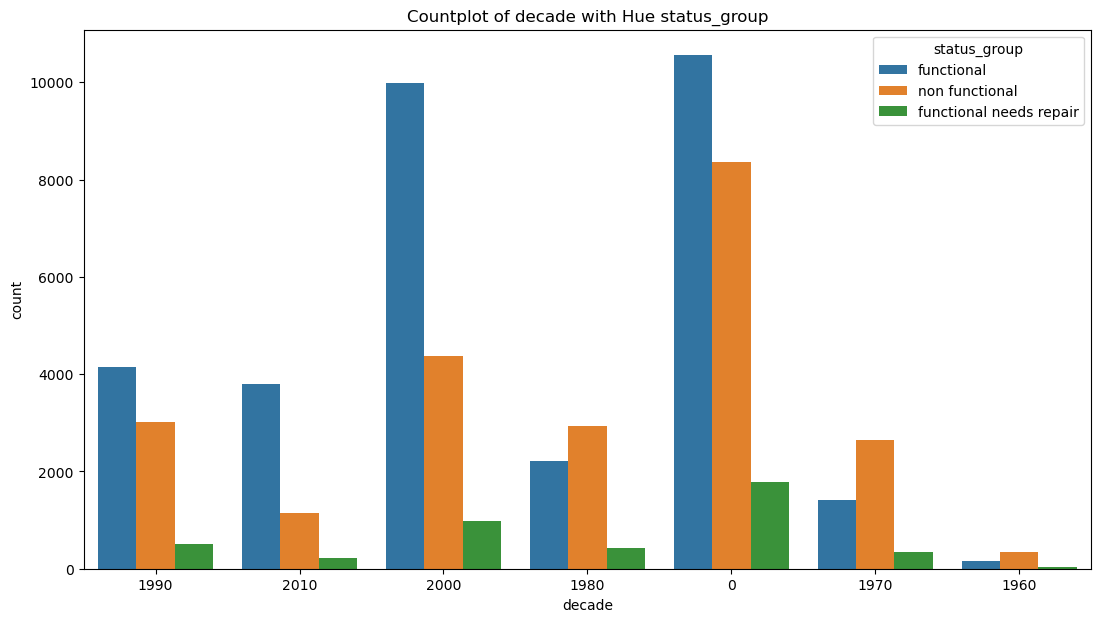

In [43]:
plot_countplot(train_df, x_col='decade')

The observation implies that there may be a positive relationship between newer pumps (built in the new millennium) and functionality; that is, newer pumps are more likely to be functional.

This might suggest that advancements in technology or construction methods over time have contributed to the improved functionality of newer wells. 

#### water_quality / quality_group columns

In [44]:
# checking for unique values
get_value_counts('water_quality')

water_quality
soft                  50818
salty                  4856
unknown                1876
milky                   804
coloured                490
salty abandoned         339
fluoride                200
fluoride abandoned       17
Name: count, dtype: int64

In [45]:
# checking for unique values
get_value_counts('quality_group')

quality_group
good        50818
salty        5195
unknown      1876
milky         804
colored       490
fluoride      217
Name: count, dtype: int64

'water_quality' column has more unique values, so we will keep 'water_quality' and drop 'quality_group'

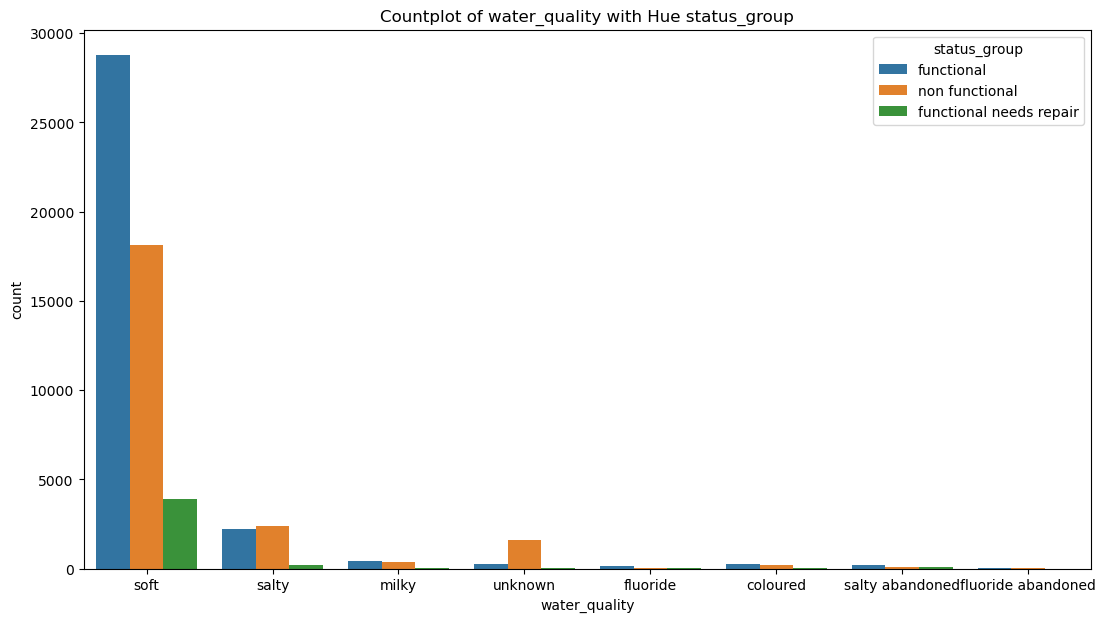

In [46]:
plot_countplot(train_df, x_col='water_quality')

We can see that even in wells with soft, good quality water, we still have non-functional wells. Where wells are salty, most are non-functional.

#### recorded_by column

In [47]:
# checking for unique values
get_value_counts('recorded_by')

recorded_by
GeoData Consultants Ltd    59400
Name: count, dtype: int64

This column has only one value so we will drop it will have no effect in our prediction.

#### installer column

In [48]:
#checking for nulls
train_df['installer'].isna().sum()

3655

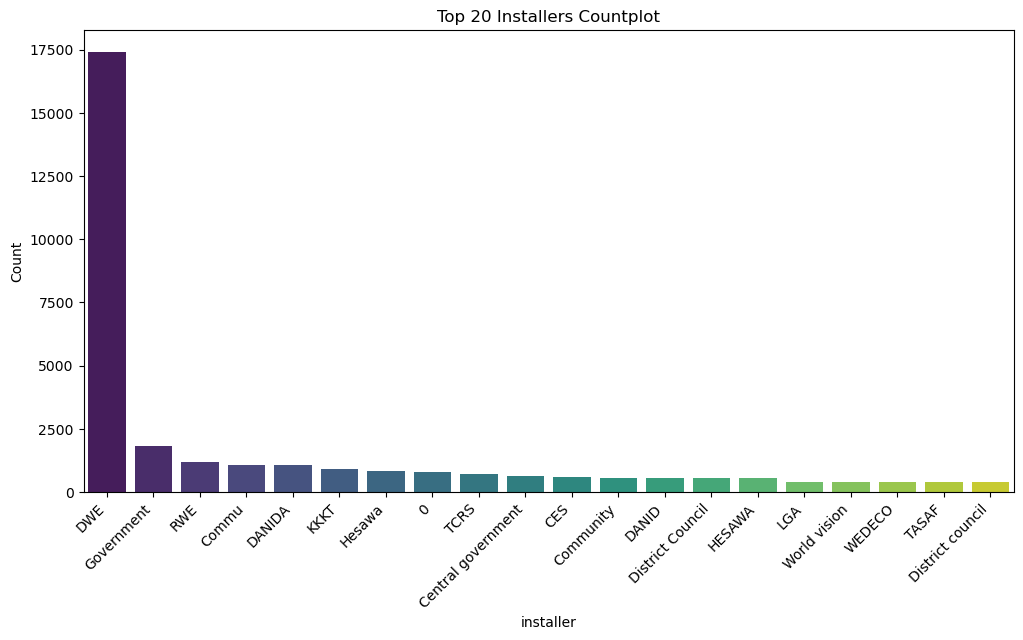

In [49]:
# function for top installers
def plot_countplot2(df, x_col, top_n=20):
    # Get the top n installers
    top_installers = df[x_col].value_counts().nlargest(top_n).index

    # Filter df for the top installers
    df_top = df[df[x_col].isin(top_installers)]

    # Create a countplot
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_top, x=x_col, order=top_installers, palette='viridis')
    plt.title(f'Top {top_n} Installers Countplot')
    plt.xlabel(x_col)
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# plot top 20 installers
plot_countplot2(train_df, x_col='installer', top_n=20)

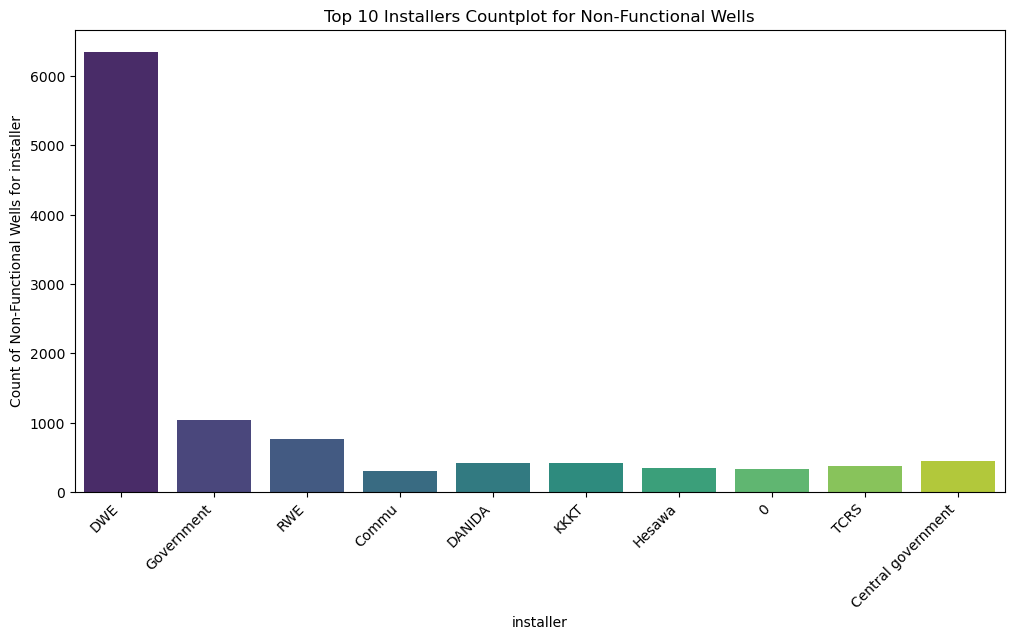

In [50]:
def plot_countplot3(df, x_col, target_col, top_n=10):
    # Get the top N installers
    top_installers = df[x_col].value_counts().nlargest(top_n).index

    # Filter the DataFrame for the top installers and non-functional instances
    df_top = df[df[x_col].isin(top_installers) & (df[target_col] == 'non functional')]

    # Create a countplot
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df_top, x=x_col, order=top_installers, palette='viridis')
    plt.title(f'Top {top_n} Installers Countplot for Non-Functional Wells')
    plt.xlabel(x_col)
    plt.ylabel(f'Count of Non-Functional Wells for {x_col}')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Assuming 'status_group' is the column representing the target variable
# Replace it with the actual column name in your DataFrame
target_column = 'status_group'

# plot top 10 installers for non-functional wells
plot_countplot3(train_df, x_col='installer', target_col=target_column, top_n=10)

This column however has lots of null values, so we can drop it.

#### funder column

In [51]:
train_df['funder'].isna().sum()

3637

This column has lots of null values, so we can drop it.

#### wpt_name / scheme_name columns

In [52]:
# checking for unique values
get_value_counts('wpt_name').nunique()

76

In [53]:
# checking for unique values
get_value_counts('scheme_name').nunique()

106

Drop the two columns above.

#### region/ region_code columns

In [54]:
# checking for unique values
get_value_counts('region_code')

region_code
11    5300
17    5011
12    4639
3     4379
5     4040
18    3324
19    3047
2     3024
16    2816
10    2640
4     2513
1     2201
13    2093
14    1979
20    1969
15    1808
6     1609
21    1583
80    1238
60    1025
90     917
7      805
99     423
9      390
24     326
8      300
40       1
Name: count, dtype: int64

In [55]:
# checking for unique values
get_value_counts('region')

region
Iringa           5294
Shinyanga        4982
Mbeya            4639
Kilimanjaro      4379
Morogoro         4006
Arusha           3350
Kagera           3316
Mwanza           3102
Kigoma           2816
Ruvuma           2640
Pwani            2635
Tanga            2547
Dodoma           2201
Singida          2093
Mara             1969
Tabora           1959
Rukwa            1808
Mtwara           1730
Manyara          1583
Lindi            1546
Dar es Salaam     805
Name: count, dtype: int64

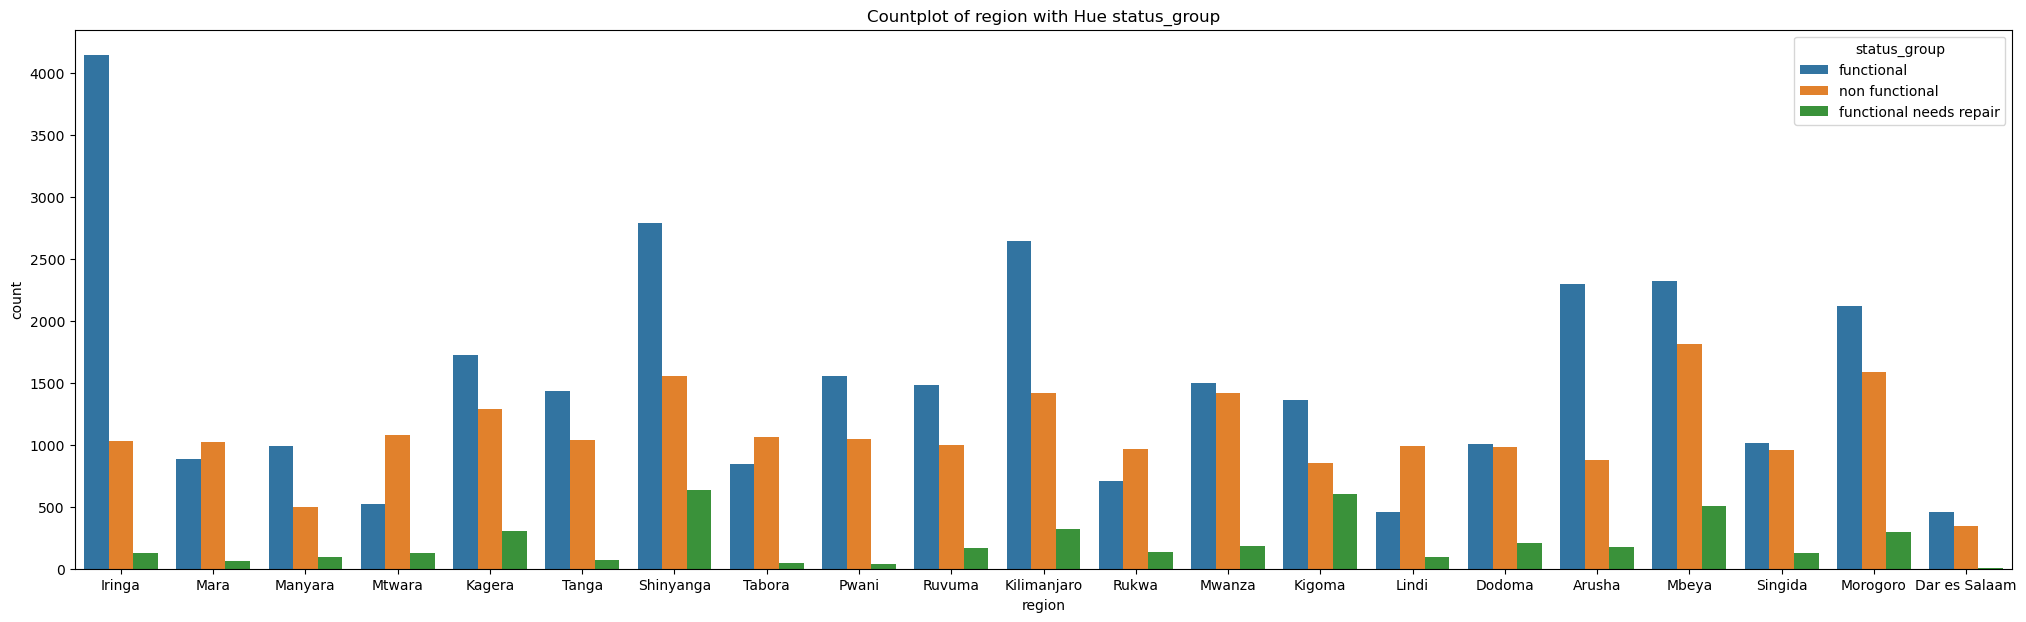

In [56]:
plot_countplot(train_df, x_col='region', hue_col= 'status_group', fig_size=(25,7))

In the majority of areas, it is evident that a significant proportion of wells are operational. However, in specific regions such as Mara, Mwara, Tabora, and Lindi, there is a higher prevalence of non-functional wells. Additionally, despite having a higher overall number of functional wells, regions like Kagera, Shinyanga, Kilimanjaro, Mwanza, Mbeya, and Morogoro exhibit a notable number of non-functional wells.

Checking Tanzania's largest city and financial hub, Dar es Salaam, we see:

In [57]:
result_df = train_df[train_df['region'] == 'Dar es Salaam'].groupby(['water_quality', 'status_group']).size().reset_index(name='count')
result_df

,water_quality,status_group,count
0,fluoride abandoned,non functional,2
1,milky,functional,1
2,milky,non functional,1
3,salty,functional,41
4,salty,non functional,100
5,salty abandoned,functional,63
6,salty abandoned,non functional,37
7,soft,functional,352
8,soft,functional needs repair,3
9,soft,non functional,186


We can see that even in the most populated region of the country, which is also one of the capitals, there is still lots of non-functional wells.

#### amount_tsh column

In [58]:
# checking for unique values
get_value_counts('amount_tsh').nunique()

50

#### gps_height column

In [59]:
train_df.groupby('status_group')[['gps_height']].mean()

,gps_height
status_group,
functional,740.131188
functional needs repair,627.607135
non functional,574.464774


In [60]:
# checking for unique values
get_value_counts('gps_height')/get_value_counts('gps_height').nunique()

gps_height
 0       385.622642
-15        1.132075
-16        1.037736
-13        1.037736
 1290      0.981132
            ...    
 2378      0.018868
-54        0.018868
 2057      0.018868
 2332      0.018868
 2366      0.018868
Name: count, Length: 2428, dtype: float64

Gps height shows the level of the water point from sea level. We can see 0 values but we'll assume they are at sea level.

#### population column

In [61]:
# checking for unique values
get_value_counts('population')

population
0       21381
1        7025
200      1940
150      1892
250      1681
        ...  
6330        1
5030        1
656         1
948         1
788         1
Name: count, Length: 1049, dtype: int64

In [62]:
train_df.loc[train_df['population']==0].groupby('status_group').count()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status,decade
status_group,,,,,,,,,,,,,,,,,,,,,
functional,11274,11274,10047,11274,10033,11274,11274,11274,11274,11274,...,11274,11274,11274,11274,11274,11274,11274,11274,11274,11274
functional needs repair,1775,1775,1464,1775,1462,1775,1775,1775,1775,1775,...,1775,1775,1775,1775,1775,1775,1775,1775,1775,1775
non functional,8332,8332,7752,8332,7755,8332,8332,8331,8332,8332,...,8332,8332,8332,8332,8332,8332,8332,8332,8332,8332


In [63]:
train_df['population'].mean()

179.90998316498317

Some functional water points has zero population which is quite weird so we will change 0 population to mean.

In [64]:
#changing 0's to mean
train_df['population'].replace(to_replace = 0 , value =180, inplace=True) 

In [65]:
train_df.sort_values(by='population', ascending=False).head(40).groupby('status_group').count()

,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,...,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status,decade
status_group,,,,,,,,,,,,,,,,,,,,,
functional,29,29,28,29,28,29,29,29,29,29,...,29,29,29,29,29,29,29,29,29,29
functional needs repair,4,4,3,4,3,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
non functional,7,7,7,7,7,7,7,7,7,7,...,7,7,7,7,7,7,7,7,7,7


To see the most populated areas water point functionality , we chose top 40 values and did groupby. It shows that higher population areas have more functional water points.

#### date_recorded column

Approximately 95% of the water points were recorded between 2011-2013. So, for now we do not think it contains necessary information about functionality. We drop this column for now.

#### num_private column

This column has no information about it and also mostly have zero values. So, we drop this also.

#### basin column

In [66]:
# checking for unique values
get_value_counts('basin')

basin
Lake Victoria              10248
Pangani                     8940
Rufiji                      7976
Internal                    7785
Lake Tanganyika             6432
Wami / Ruvu                 5987
Lake Nyasa                  5085
Ruvuma / Southern Coast     4493
Lake Rukwa                  2454
Name: count, dtype: int64

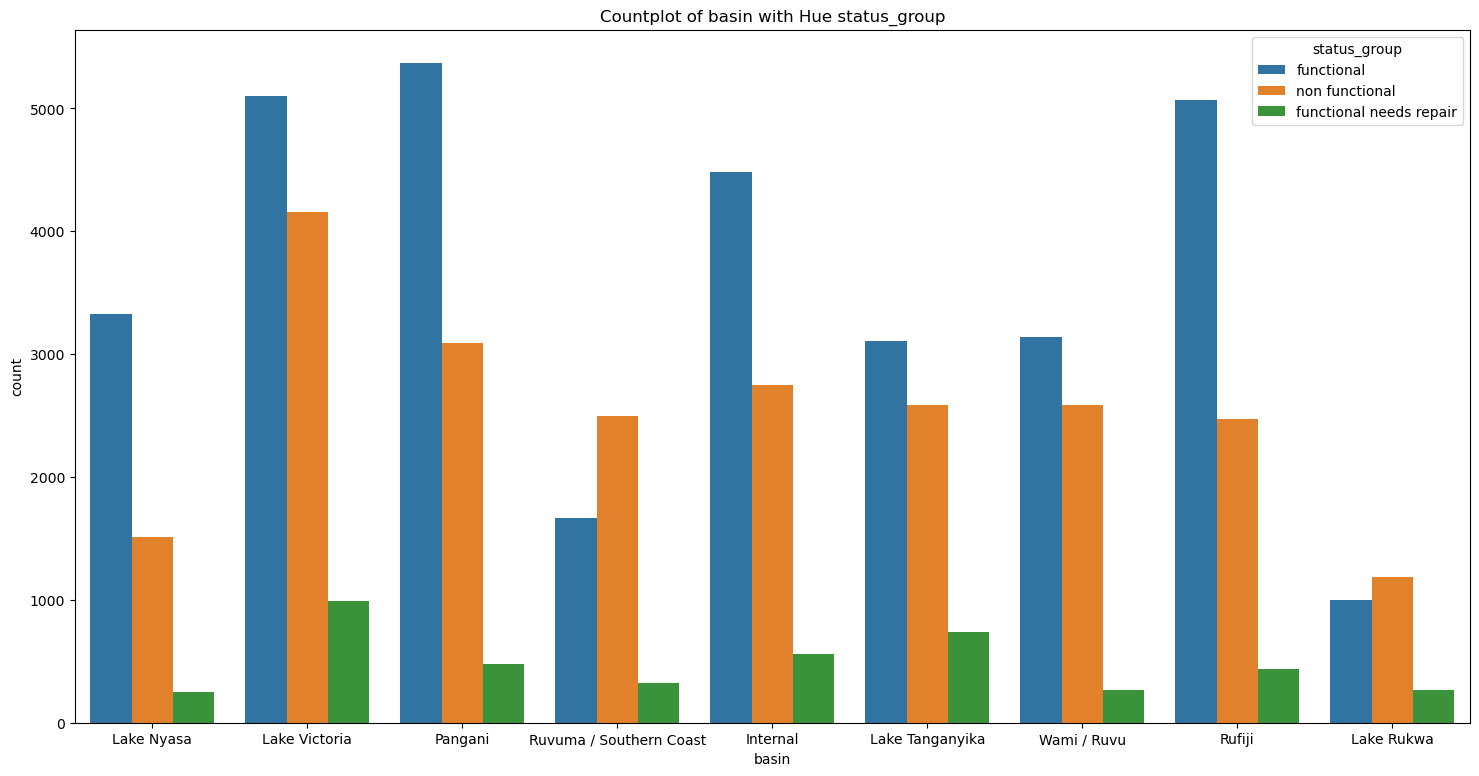

In [67]:
plot_countplot(train_df, x_col='basin', fig_size=(18,9))

This graph shows that there is a correlation between functionality and geographical water basin.

#### subvillage column

In [68]:
# checking for unique values
get_value_counts('subvillage')

subvillage
Madukani        508
Shuleni         506
Majengo         502
Kati            373
Mtakuja         262
               ... 
Kipompo           1
Chanyamilima      1
Ikalime           1
Kemagaka          1
Kikatanyemba      1
Name: count, Length: 19287, dtype: int64

This column has location value of water point regions but we already have region column. We will drop this, because it is hard to handle this nunique object values.

#### district_code column

In [69]:
# checking for unique values
get_value_counts('district_code')

district_code
1     12203
2     11173
3      9998
4      8999
5      4356
6      4074
7      3343
8      1043
30      995
33      874
53      745
43      505
13      391
23      293
63      195
62      109
60       63
0        23
80       12
67        6
Name: count, dtype: int64

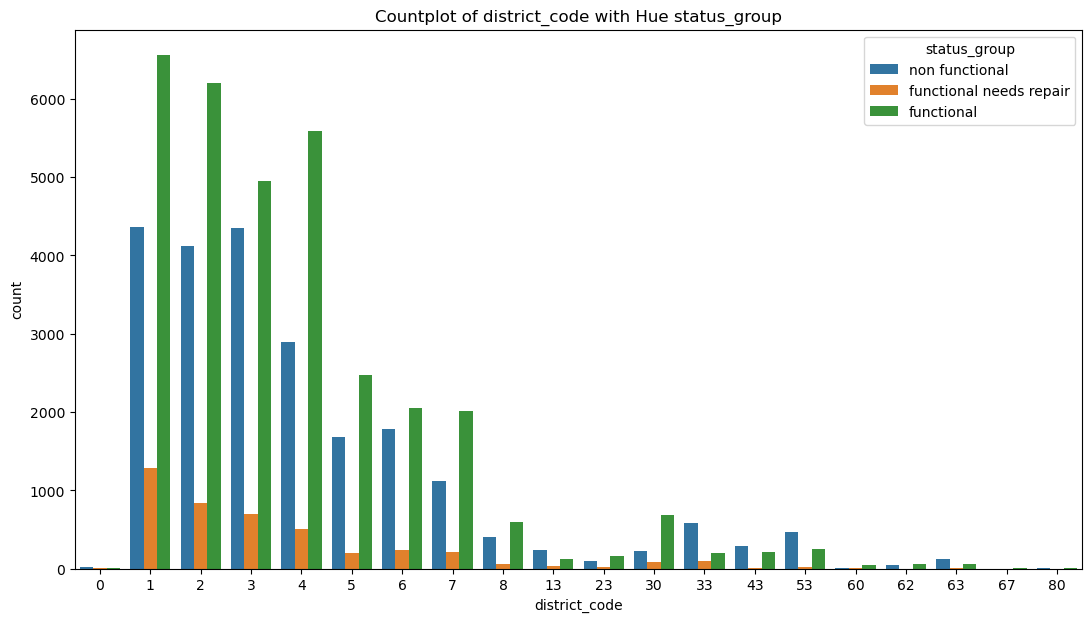

In [70]:
plot_countplot(train_df, x_col='district_code')

Most of the districts have functional wells.

#### public_meeting columns

In [71]:
# checking for unique values
get_value_counts('public_meeting')

public_meeting
True     51011
False     5055
Name: count, dtype: int64

#### permit column

In [72]:
# checking for unique values
get_value_counts('permit')

permit
True     38852
False    17492
Name: count, dtype: int64

This column shows if the water point is permitted or not. 

### 2.2 Data Cleaning Cont.

#### Dropping all irrelavant features in train_df

In [73]:
# dropping all the irrelavant features
train_df = train_df.drop(['scheme_name', 
                         'num_private', 
                         'lga', 
                         'ward',
                         'recorded_by', 
                         'extraction_type',
                         'extraction_type_class',
                         'management_group',
                         'payment',
                         'water_quality',
                         'quantity',
                         'source',
                         'source_class',
                         'waterpoint_type',
                         'date_recorded',
                         'public_meeting',
                         'scheme_management',
                         'funder',
                         'installer',
                         'wpt_name',
                          'decade',
                         'subvillage'], axis=1)

In [74]:
train_df

,status_group,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,permit,construction_year,extraction_type_group,management,payment_type,quality_group,quantity_group,source_type,waterpoint_type_group,status
id,,,,,,,,,,,,,,,,,,,,
69572,functional,6000.0,1390,34.938093,-9.856322,Lake Nyasa,Iringa,11,5,109,False,1999,gravity,vwc,annually,good,enough,spring,communal standpipe,2
8776,functional,0.0,1399,34.698766,-2.147466,Lake Victoria,Mara,20,2,280,True,2010,gravity,wug,never pay,good,insufficient,rainwater harvesting,communal standpipe,2
34310,functional,25.0,686,37.460664,-3.821329,Pangani,Manyara,21,4,250,True,2009,gravity,vwc,per bucket,good,enough,dam,communal standpipe,2
67743,non functional,0.0,263,38.486161,-11.155298,Ruvuma / Southern Coast,Mtwara,90,63,58,True,1986,submersible,vwc,never pay,good,dry,borehole,communal standpipe,0
19728,functional,0.0,0,31.130847,-1.825359,Lake Victoria,Kagera,18,1,180,True,2000,gravity,other,never pay,good,seasonal,rainwater harvesting,communal standpipe,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60739,functional,10.0,1210,37.169807,-3.253847,Pangani,Kilimanjaro,3,5,125,True,1999,gravity,water board,per bucket,good,enough,spring,communal standpipe,2
27263,functional,4700.0,1212,35.249991,-9.070629,Rufiji,Iringa,11,4,56,True,1996,gravity,vwc,annually,good,enough,river/lake,communal standpipe,2
37057,functional,0.0,0,34.017087,-8.750434,Rufiji,Mbeya,12,7,180,False,2000,swn 80,vwc,monthly,fluoride,enough,borehole,hand pump,2


In [75]:
# shows Nan value after initial data cleaning
train_df.isna().sum()

status_group                0
amount_tsh                  0
gps_height                  0
longitude                   0
latitude                    0
basin                       0
region                      0
region_code                 0
district_code               0
population                  0
permit                   3056
construction_year           0
extraction_type_group       0
management                  0
payment_type                0
quality_group               0
quantity_group              0
source_type                 0
waterpoint_type_group       0
status                      0
dtype: int64

In [76]:
# drop all the Nan in our data frame
train_df = train_df.dropna()

In [77]:
# confirm there are no missing data
train_df.isna().sum()

status_group             0
amount_tsh               0
gps_height               0
longitude                0
latitude                 0
basin                    0
region                   0
region_code              0
district_code            0
population               0
permit                   0
construction_year        0
extraction_type_group    0
management               0
payment_type             0
quality_group            0
quantity_group           0
source_type              0
waterpoint_type_group    0
status                   0
dtype: int64

In [78]:
# switch boolean values to integer objects
train_df['permit'] = train_df['permit'].astype(int)

### 2.3 Cleaning Submission Wells (Test Data)

In [79]:
X_submission = X_submission.drop(['scheme_name', 
                         'num_private', 
                         'lga', 
                         'ward',
                         'recorded_by', 
                         'extraction_type',
                         'extraction_type_class',
                         'management_group',
                         'payment',
                         'water_quality',
                         'quantity',
                         'source',
                         'source_class',
                         'waterpoint_type',
                         'date_recorded',
                         'public_meeting',
                         'scheme_management', 
                         'funder',
                         'installer',
                         'wpt_name',
                         'subvillage'], axis=1)

In [80]:
X_submission

,id,amount_tsh,gps_height,longitude,latitude,basin,region,region_code,district_code,population,permit,construction_year,extraction_type_group,management,payment_type,quality_group,quantity_group,source_type,waterpoint_type_group
0,50785,0.0,1996,35.290799,-4.059696,Internal,Manyara,21,3,321,True,2012,other,parastatal,never pay,good,seasonal,rainwater harvesting,other
1,51630,0.0,1569,36.656709,-3.309214,Pangani,Arusha,2,2,300,True,2000,gravity,vwc,never pay,good,insufficient,spring,communal standpipe
2,17168,0.0,1567,34.767863,-5.004344,Internal,Singida,13,2,500,NaN,2010,other,vwc,never pay,good,insufficient,rainwater harvesting,other
3,45559,0.0,267,38.058046,-9.418672,Ruvuma / Southern Coast,Lindi,80,43,250,True,1987,other,vwc,unknown,good,dry,shallow well,other
4,49871,500.0,1260,35.006123,-10.950412,Ruvuma / Southern Coast,Ruvuma,10,3,60,True,2000,gravity,water board,monthly,good,enough,spring,communal standpipe
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14845,39307,0.0,34,38.852669,-6.582841,Wami / Ruvu,Pwani,6,1,20,True,1988,mono,vwc,never pay,good,enough,river/lake,communal standpipe
14846,18990,1000.0,0,37.451633,-5.350428,Pangani,Tanga,4,7,2960,False,1994,nira/tanira,vwc,annually,salty,insufficient,shallow well,hand pump
14847,28749,0.0,1476,34.739804,-4.585587,Internal,Singida,13,2,200,NaN,2010,gravity,vwc,never pay,good,insufficient,dam,communal standpipe
14848,33492,0.0,998,35.432732,-10.584159,Lake Nyasa,Ruvuma,10,2,150,True,2009,gravity,vwc,never pay,good,insufficient,river/lake,communal standpipe


In [81]:
#drop nulls and change permit type
X_submission = X_submission.dropna()
X_submission['permit'] = X_submission['permit'].astype(int)
X_submission = X_submission.set_index('id')

X_submission.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14113 entries, 50785 to 68707
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   amount_tsh             14113 non-null  float64
 1   gps_height             14113 non-null  int64  
 2   longitude              14113 non-null  float64
 3   latitude               14113 non-null  float64
 4   basin                  14113 non-null  object 
 5   region                 14113 non-null  object 
 6   region_code            14113 non-null  int64  
 7   district_code          14113 non-null  int64  
 8   population             14113 non-null  int64  
 9   permit                 14113 non-null  int32  
 10  construction_year      14113 non-null  int64  
 11  extraction_type_group  14113 non-null  object 
 12  management             14113 non-null  object 
 13  payment_type           14113 non-null  object 
 14  quality_group          14113 non-null  object 
 15  qua

### 2.4 Removing Outliers in both datasets

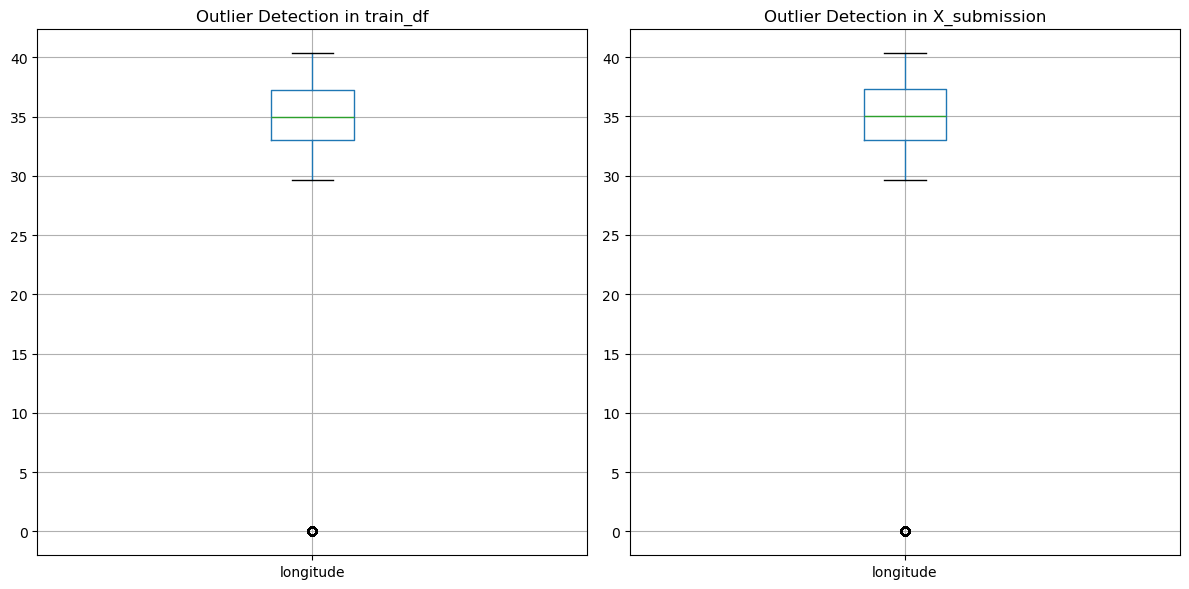

In [82]:
# Plot box plots to visualize outliers in the datasets
dataframes = [('train_df', train_df), ('X_submission', X_submission)]

# Plot side-by-side boxplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for ax, (name, df) in zip(axes, dataframes):
    df[['longitude']].boxplot(ax=ax)
    ax.set_title(f'Outlier Detection in {name}')

plt.tight_layout()
plt.show()

In [83]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = train_df[['longitude']].quantile(0.25)
Q3 = train_df[['longitude']].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers from training data
train_df = train_df[~((train_df[['longitude']] < (Q1 - 1.5 * IQR)) | 
                                           (train_df[['longitude']] > (Q3 + 1.5 * IQR))).any(axis=1)]

In [84]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = X_submission[['longitude']].quantile(0.25)
Q3 = X_submission[['longitude']].quantile(0.75)
IQR = Q3 - Q1

# Remove outliers from test data
X_submission = X_submission[~((X_submission[['longitude']] < (Q1 - 1.5 * IQR)) | 
                                           (X_submission[['longitude']] > (Q3 + 1.5 * IQR))).any(axis=1)]

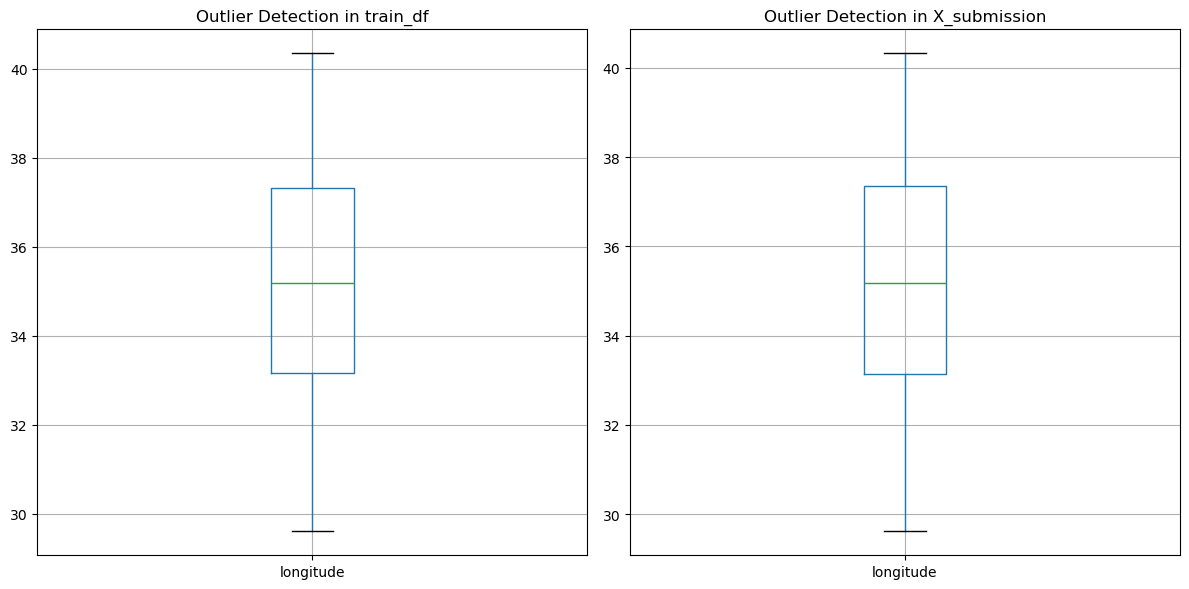

In [85]:
# Plot box plots to visualize outliers in the datasets
dataframes = [('train_df', train_df), ('X_submission', X_submission)]

# Plot side-by-side boxplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for ax, (name, df) in zip(axes, dataframes):
    df[['longitude']].boxplot(ax=ax)
    ax.set_title(f'Outlier Detection in {name}')

plt.tight_layout()
plt.show()

## 3. Exploratory Data Analysis

### A. Univariate Analysis

(more univariate analysis has been handled during data wrangling)

#### Distribution of target variable 'status_group'

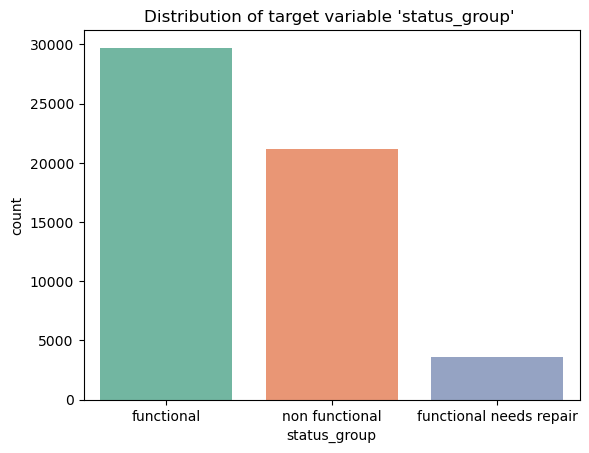

In [86]:
# Create the plot
#plt.figure(figsize=(10, 6))
sns.countplot(x='status_group', data=train_df, palette='Set2') 

# Add the title
plt.title("Distribution of target variable 'status_group' ")

# Show the plot
plt.show()

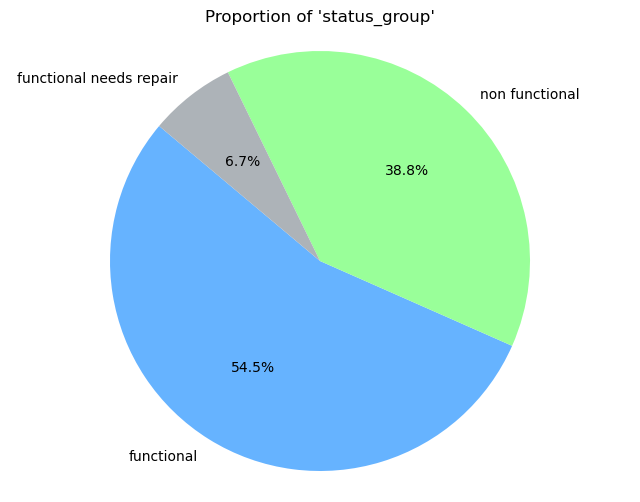

In [87]:
# Visualize normalized proportions

proportions = train_df['status_group'].value_counts(normalize=True)

plt.figure(figsize=(8, 6))
plt.pie(proportions, labels=proportions.index, autopct='%1.1f%%', colors=['#66b3ff', '#99ff99','#Adb3b8'], startangle=140)
plt.title("Proportion of 'status_group'")
plt.axis('equal') 
plt.show()

This data shows that **54.6%** of the water points recorded are successfully providing clean water to people across Tanzania. However, **39.0%** of the water points are not operational, highlighting a potential area of concern for water access. Identifying why these waterpoints are non-functional and addressing these issues would be critical for improving water availability

### B. Bivariate Analaysis

#### Distribution of 'status_group' against 'extraction_type'

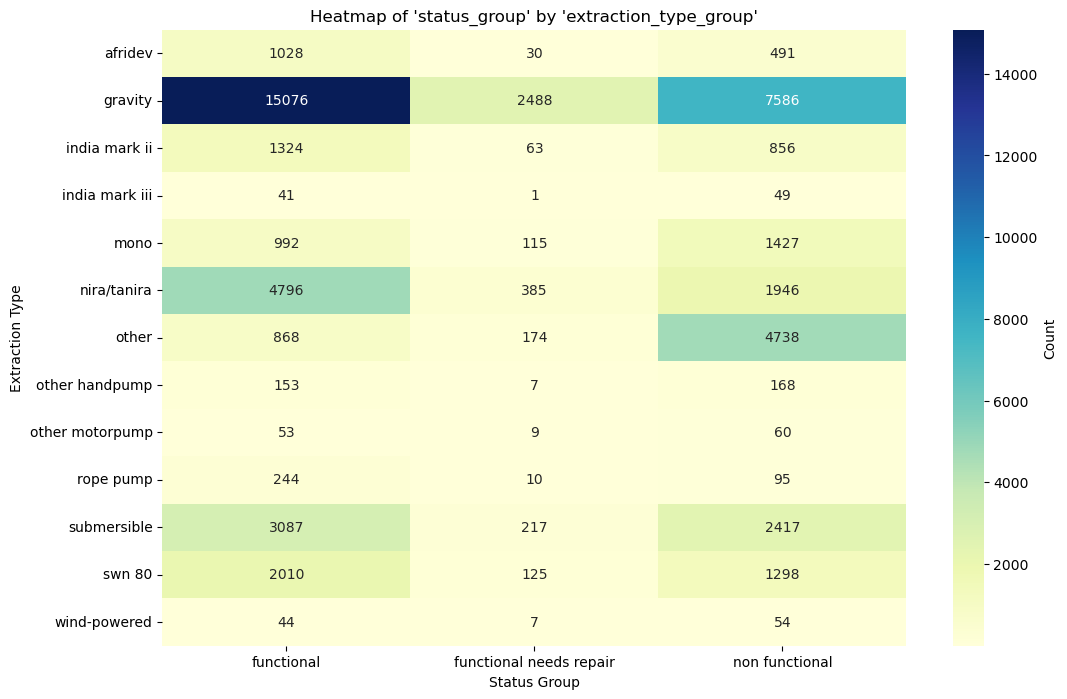

In [88]:
# Create a crosstab for 'extraction_type' and 'status_group'
cross_tab = pd.crosstab(train_df['extraction_type_group'], train_df['status_group'])

# Plot a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='YlGnBu', cbar_kws={'label': 'Count'})

# Add title and labels
plt.title("Heatmap of 'status_group' by 'extraction_type_group'")
plt.xlabel('Status Group')
plt.ylabel('Extraction Type')

# Show the plot
plt.show()

The largest group of functional waterpoints uses **gravity-fed systems, (13709)**, but there is also a significant number of **non-functional systems,
(6934)**. From this data we see that while gravity-fed systems are widely used and often reliable, they may also be prone to failure if not properly maintained

**Nira/Tanira** and **submersible** handpumps are predominantly functional (**4796** and **3087**, respectively).

### C. Multivariate Analysis

#### Visualizing Geospatial Distribution of Waterpoints

<Figure size 1000x800 with 0 Axes>

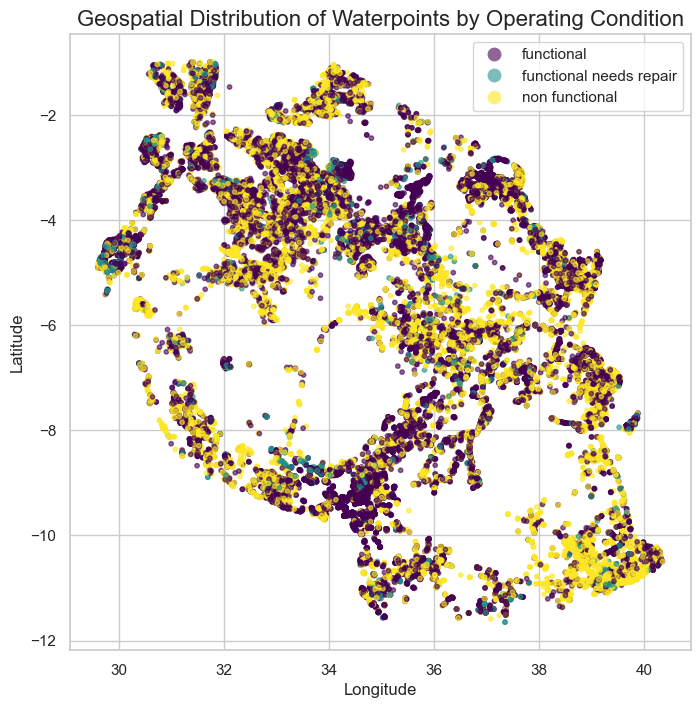

In [89]:
# Convert the DataFrame to a GeoDataFrame
train_merge_gdf = gpd.GeoDataFrame(
    train_df, geometry=gpd.points_from_xy(train_df.longitude, train_df.latitude)
)

# Plotting
plt.figure(figsize=(10, 8))
sns.set(style="whitegrid")

# Plot geospatial points colored by status_group
train_merge_gdf.plot(column='status_group', cmap='viridis', legend=True, markersize=10, alpha=0.6, figsize=(12, 8))

# Customize plot
plt.title('Geospatial Distribution of Waterpoints by Operating Condition', fontsize=16)
plt.xlabel('Longitude', fontsize=12)
plt.ylabel('Latitude', fontsize=12)

# Show plot
plt.show()

The map shows a significant number of waterpoints that are either non-functional or require repairs (yellow and teal). The widespread distribution of these problematic waterpoints suggests that there are areas across Tanzania where access to clean water is compromised.

Clusters of yellow and teal points indicate regions where water infrastructure might be failing or in need of urgent attention. These clusters can guide field investigations and interventions.

## 4. Data Preprocessing for Machine Learning

In [90]:
# preping data for train test split
X = train_df.drop(['status_group', 'status'], axis=1)
y = train_df['status']

In [91]:
# splitting the documented well data before preprocessing to preven data leakage
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= .2, random_state=42)

In [92]:
# instantiate onehotencoder and stardardscaler
ohe = OneHotEncoder(categories='auto', sparse_output=False, drop='first')
ss = StandardScaler()

### Preprocessing Training Data

In [93]:
# Use onehotencoder on all the categorical columns
# Extracting categorical columns from X_train
X_train_ohe = X_train.select_dtypes('object')

# Concatenate categorical columns and selected numerical columns (district_code, region_code)
X_train_ohe = pd.concat([X_train_ohe, X_train[['district_code', 'region_code']]], axis=1)

# Initialize and fit the OneHotEncoder
ohe.fit(X_train_ohe)

# Transform the training data using the fitted OneHotEncoder
X_train_transformed = ohe.transform(X_train_ohe)

# Create a dfwith the transformed features 
train_df_transformed = pd.DataFrame(X_train_transformed, columns=ohe.get_feature_names_out(), index=X_train.index)

# Use standard scaler to scale values with the same unit
# Extract numerical columns excluding specific features (district_code, permit, region_code)
X_train_ss = X_train.select_dtypes(exclude='object').drop(['district_code', 'permit', 'region_code'], axis=1)

# Initialize and fit the StandardScaler
ss.fit(X_train_ss)

# Transform the selected numerical features using the fitted StandardScaler
X_train_scaled = ss.transform(X_train_ss)

# Create a DataFrame with the scaled numerical features
train_df1 = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train_ss.columns)

# Extract the 'permit' column
train_df2 = X_train[['permit']]

# Concatenate the cleaned numerical and categorical features
X_train_clean = pd.concat([train_df1, train_df2, train_df_transformed], axis=1)
X_train_clean.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,permit,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,...,region_code_18,region_code_19,region_code_20,region_code_21,region_code_24,region_code_40,region_code_60,region_code_80,region_code_90,region_code_99
id,,,,,,,,,,,,,,,,,,,,,
58678,-0.118322,1.007919,-1.722610,0.805450,-0.295126,0.494318,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23367,-0.118322,-0.981958,-0.804940,1.244555,-0.153765,0.204423,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40252,-0.118322,-0.385719,1.323439,-1.547495,-0.295126,-0.955158,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,-0.083445,-0.531884,0.622784,-1.082551,-0.575491,0.590950,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42343,-0.118322,-0.981958,-1.011953,-0.963302,-0.153765,0.204423,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [94]:
# Use onehotencoder on all the categorical columns
# Extracting categorical columns from X_train
X_train_ohe = X_train.select_dtypes('object')

# Concatenate categorical columns and selected numerical columns (district_code, region_code)
X_train_ohe = pd.concat([X_train_ohe, X_train[['district_code', 'region_code']]], axis=1)

# Initialize and fit the OneHotEncoder
ohe.fit(X_train_ohe)

# Transform the training data using the fitted OneHotEncoder
X_train_transformed = ohe.transform(X_train_ohe)

# Create a dfwith the transformed features 
train_df_transformed = pd.DataFrame(X_train_transformed, columns=ohe.get_feature_names_out(), index=X_train.index)

# Use standard scaler to scale values with the same unit
# Extract numerical columns excluding specific features (district_code, permit, region_code)
X_train_ss = X_train.select_dtypes(exclude='object').drop(['district_code', 'permit', 'region_code'], axis=1)

# Initialize and fit the StandardScaler
ss.fit(X_train_ss)

# Transform the selected numerical features using the fitted StandardScaler
X_train_scaled = ss.transform(X_train_ss)

# Create a DataFrame with the scaled numerical features
train_df1 = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train_ss.columns)

# Extract the 'permit' column
train_df2 = X_train[['permit']]

# Concatenate the cleaned numerical and categorical features
X_train_clean = pd.concat([train_df1, train_df2, train_df_transformed], axis=1)
X_train_clean.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,permit,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,...,region_code_18,region_code_19,region_code_20,region_code_21,region_code_24,region_code_40,region_code_60,region_code_80,region_code_90,region_code_99
id,,,,,,,,,,,,,,,,,,,,,
58678,-0.118322,1.007919,-1.722610,0.805450,-0.295126,0.494318,0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23367,-0.118322,-0.981958,-0.804940,1.244555,-0.153765,0.204423,1,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40252,-0.118322,-0.385719,1.323439,-1.547495,-0.295126,-0.955158,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
601,-0.083445,-0.531884,0.622784,-1.082551,-0.575491,0.590950,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42343,-0.118322,-0.981958,-1.011953,-0.963302,-0.153765,0.204423,0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preprocessing Test Data

In [95]:
# Use onehotencoder on all the categorical columns for the test dataset
# Extracting categorical columns from X_test
X_test_ohe = X_test.select_dtypes('object')

# Concatenate categorical columns and selected numerical columns (district_code, region_code)
X_test_ohe = pd.concat([X_test_ohe, X_test[['district_code', 'region_code']]], axis=1)

# Transform the test dataset using the fitted OneHotEncoder from training data
X_test_transformed = ohe.transform(X_test_ohe)

# Create a df with the transformed features 
test_df_transformed = pd.DataFrame(X_test_transformed, columns=ohe.get_feature_names_out(), index=X_test.index)

# Use standard scaler to scale values with the same unit for the test dataset
# Extract numerical columns excluding specific features (permit, region_code, district_code)
X_test_ss = X_test.select_dtypes(exclude='object').drop(['permit', 'region_code', 'district_code'], axis=1)

# Transform the selected numerical features using the fitted StandardScaler from training data
X_test_scaled = ss.transform(X_test_ss)

# Create a DataFrame with the scaled numerical features for the test dataset
test_df1 = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test_ss.columns)

# Extract the 'permit' column for the test dataset
test_df2 = X_test[['permit']]

# Concatenate the cleaned numerical and categorical features for the test dataset
X_test_clean = pd.concat([test_df1, test_df2, test_df_transformed], axis=1)
X_test_clean.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,permit,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,...,region_code_18,region_code_19,region_code_20,region_code_21,region_code_24,region_code_40,region_code_60,region_code_80,region_code_90,region_code_99
id,,,,,,,,,,,,,,,,,,,,,
35794,-0.111347,1.279990,0.145369,0.546747,0.018224,0.494318,1,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2733,-0.118322,-0.501493,0.942300,-0.097859,-0.575491,-1.631580,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
59856,-0.118322,-0.981958,0.798029,0.073909,3.036273,-0.858526,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27282,-0.114835,1.346560,0.235556,0.935069,-0.460046,1.074109,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21452,-0.118322,-0.981958,-1.300043,1.253700,-0.153765,0.204423,1,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preprocessing Submission Data

In [96]:
# Create a copy of the submission dataset
x_sub = X_submission.copy()

# Extract categorical columns for the submission dataset
x_sub_ohe = x_sub.select_dtypes('object')

# Concatenate categorical columns and selected numerical columns (district_code, region_code)
x_sub_ohe = pd.concat([x_sub_ohe, x_sub[['district_code', 'region_code']]], axis=1)

# Transform the submission dataset using the fitted OneHotEncoder from training data
x_sub_transformed = ohe.transform(x_sub_ohe)

# Create a DataFrame with the transformed features
submission_df = pd.DataFrame(x_sub_transformed, columns=ohe.get_feature_names_out(), index=x_sub.index)

# Extract numerical columns excluding specific features (permit, region_code, district_code) for the submission dataset
x_sub_ss = x_sub.select_dtypes(exclude='object').drop(['permit', 'region_code', 'district_code'], axis=1)

# Transform the selected numerical features using the fitted StandardScaler from training data for the submission dataset
x_sub_scaled = ss.transform(x_sub_ss)

# Create a df with the scaled numerical features for the submission dataset
sub_df1 = pd.DataFrame(x_sub_scaled, index=x_sub.index, columns=x_sub_ss.columns)

# Extract the 'permit' column for the submission dataset
sub_df2 = x_sub[['permit']]

# Concatenate the cleaned numerical and categorical features for the submission dataset
submission_clean = pd.concat([sub_df1, sub_df2, submission_df], axis=1)
submission_clean.head()

,amount_tsh,gps_height,longitude,latitude,population,construction_year,permit,basin_Lake Nyasa,basin_Lake Rukwa,basin_Lake Tanganyika,...,region_code_18,region_code_19,region_code_20,region_code_21,region_code_24,region_code_40,region_code_60,region_code_80,region_code_90,region_code_99
id,,,,,,,,,,,,,,,,,,,,,
50785,-0.118322,1.906620,0.043628,0.651426,0.178433,1.364004,1,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
51630,-0.118322,1.288673,0.557005,0.918257,0.128956,0.204423,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
45559,-0.118322,-0.595560,1.083698,-1.253938,0.011156,-1.051790,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
49871,0.056066,0.841493,-0.063368,-1.798542,-0.436486,0.204423,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52449,-0.118322,1.456546,0.567743,0.920673,-0.106645,-0.761895,1,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 5. Modelling and Evaluation

### Classification Models

Writing a function to get model classification report and confusion matrix display:

In [97]:
def model_score(model, X, y_predict, y_true):
    # Predictions
    y_predict = model.predict(X)
    
    # Get unique class labels from y_true and y_predict
    classes = sorted(set(y_true) | set(y_predict))
    
    # Print classification report
    report = classification_report(y_true, y_predict, labels=classes, target_names=[str(c) for c in classes])
    print("Classification Report:\n", report)
    
    # Cross-validation score
    cross = cross_val_score(estimator=model, X=X, y=y_true, cv=10).mean()

    # Print cross-validation score
    print(f'Cross Validation Score: {round(cross, 5)}')

    # Confusion matrix plot
    ConfusionMatrixDisplay.from_estimator(model, X, y_true)

### A. Baseline Model- "Dummy" Model

Let's start with a completely "dummy" model, that will always choose the majority class.

Accuracy Score: 0.5413037498853946


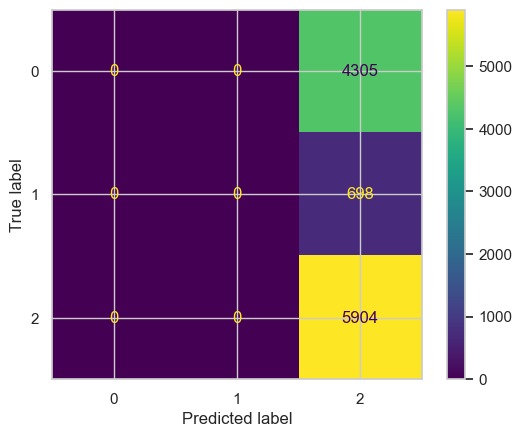

In [98]:
# Create a Dummy Classifier
dummy = DummyClassifier(random_state=42)

# Fit the Dummy Classifier on the cleaned training data
dummy.fit(X_train_clean, y_train)
print(f"Accuracy Score: {dummy.score(X_test_clean, y_test)}")

# Make predictions with dummy classifies
y_pred = dummy.predict(X_test_clean)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dummy.classes_)
disp.plot(cmap='viridis');

In [99]:
cv_results = cross_val_score(dummy, X_train, y_train, cv=5)
cv_results.mean()

0.545833810888252

The model is making predictions at a level slightly better than random chance where we would see .333 accuracy. This however is far from the accuracy we aim to achieve. The mean accuracy is a little over 53%, and we also see a loop sided confusion matrix.

### B. 2nd Model - Logistic Regression

Let's use a logistic regression model and compare its performance.

We will employ **smote** because as we saw before, our target had extremely unbalanced values, with class 1 being the lowest.

In [100]:
# Instantiating smote
smote = SMOTE(random_state= 42)
# Fitting smote
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_clean, y_train)

#### Logistic Regression

We're going to specifically avoid any regularization (the default) to see how the model does with little change. So we'll pass 'none' to the penalty parameter to not use any regularization.

In [101]:
logreg = LogisticRegression(random_state = 42)
logreg.fit(X_train_resampled,y_train_resampled)

LogisticRegression(random_state=42)

In [102]:
train_accuracy = logreg.score(X_train_resampled, y_train_resampled)
train_accuracy

0.646928719413181

The mean accuracy is better when the model is actually taking in information from the features instead of always guessing the majority class. Here we see about **65%** accuracy. This means that 65% of the time, the logistic regression model predicts correctly that a water pump is either functional, non-functional or it needs repair.

In [103]:
confusion_matrix(y_train_resampled, logreg.predict(X_train_resampled))

array([[15157,  4168,  4487],
       [ 2644, 15636,  5532],
       [ 2641,  5750, 15421]], dtype=int64)

This model is doing better, but lets improve on it.

**Using Hyperparameter tuning for the Logistic Regression Model**

In [104]:
# Creating a parameter grid for logistic regression
param_grid = [{'penalty' : ['l1', 'l2'],
               'C' : np.logspace(-1, 1, 5)}]

In [105]:
# Create a GridSearchCv
logreg_clf = GridSearchCV(estimator = logreg,
                          param_grid = param_grid,
                          cv = 3, verbose=True, n_jobs=10)

In [106]:
# Fitting using grid search
best_clf = logreg_clf.fit(X_train_resampled,y_train_resampled)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


In [107]:
# Getting the best hyperparameters for our logistic regression 
best_clf.best_params_

{'C': 10.0, 'penalty': 'l2'}

In [108]:
# Instantiating logistic regression model using the best parameters from the grid search
best_logreg = LogisticRegression(random_state = 42,multi_class ="multinomial",
                                 class_weight = "balanced",
                                 C = 0.1,penalty = "l2")

In [109]:
# Fitting the model
best_logreg.fit(X_train_resampled,y_train_resampled)

LogisticRegression(C=0.1, class_weight='balanced', multi_class='multinomial',
                   random_state=42)

**Evaluating the Tuned Logistic Regression model**

In [110]:
def plot_confusion_matrices(model, X_train, y_train, X_test, y_test):
    # Confusion matrix for training data
    y_train_pred = model.predict(X_train)
    cm_train = confusion_matrix(y_train, y_train_pred)
    disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=model.classes_)
    disp_train.plot(cmap=plt.cm.Blues, values_format=".0f")
    disp_train.ax_.set_title('Confusion Matrix - Training Data')
    plt.show()

    # Confusion matrix for testing data
    y_test_pred = model.predict(X_test)
    cm_test = confusion_matrix(y_test, y_test_pred)
    disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=model.classes_)
    disp_test.plot(cmap=plt.cm.Blues, values_format=".0f")
    disp_test.ax_.set_title('Confusion Matrix - Testing Data')
    plt.show()

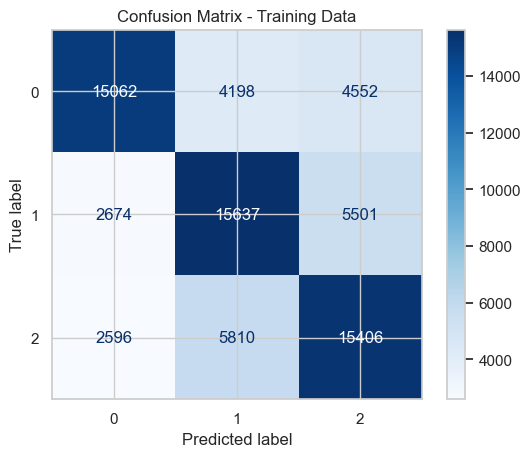

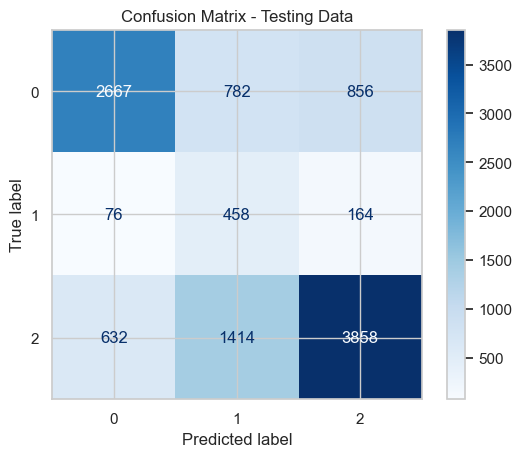

In [111]:
plot_confusion_matrices(best_logreg, X_train_resampled, y_train_resampled, X_test_clean, y_test )

In [112]:
# Predict on training and test sets
best_logreg_training_preds = best_logreg.predict(X_train_resampled)
best_logreg_preds = best_logreg.predict(X_test_clean)


# Accuracy of training and test sets
best_logreg_training_accuracy = accuracy_score(y_train_resampled, best_logreg_training_preds)
best_logreg_test_accuracy = accuracy_score(y_test, best_logreg_preds)

print('Training Accuracy: {:.4}%'.format(best_logreg_training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(best_logreg_test_accuracy * 100))

Training Accuracy: 64.54%
Validation accuracy: 64.02%


An accuracy of **64.02%** on the testing data indicates no improvement after tuning of hyperparameters. Logistic regression may be too simple to model the characteristics of this data.

In [113]:
# validate logistic regression

#train cross validation
best_logreg_train_cv_score = cross_val_score(best_logreg, X_train_resampled,
                                        y_train_resampled, cv = 5).mean()
print('Train cross validation:', best_logreg_train_cv_score)

#test cross validation
best_logreg_test_cv_score = cross_val_score(best_logreg, X_test_clean, y_test,
                                       cv = 5).mean()
print('Test cross validation:', best_logreg_test_cv_score)

Train cross validation: 0.6427712114812243
Test cross validation: 0.6341806645258548


The tuned logistic regression does not overfit but it doesn't meet target of 70% thus we try another more complex machine learning algorithm

### C. Decision Tree

We're going to specifically avoid any regularization (the default) to see how the model does with little change.

In [114]:
# Instantiate baseline model
tree_clf = DecisionTreeClassifier(random_state=42)

# Fit Decision Tree
tree_clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(random_state=42)

In [115]:
# Predict on the training set
y_hat_train_tree = tree_clf.predict(X_train_resampled)

# Predict on the test set
y_hat_test_tree = tree_clf.predict(X_test_clean)

# Train accuracy
tree_train_accuracy = accuracy_score(y_train_resampled, y_hat_train_tree) * 100
print('Train accuracy: {:.2f}%'.format(tree_train_accuracy))

# Test accuracy
tree_test_accuracy = accuracy_score(y_test, y_hat_test_tree) * 100
print('Test accuracy: {:.2f}%'.format(tree_test_accuracy))

Train accuracy: 100.00%
Test accuracy: 74.19%


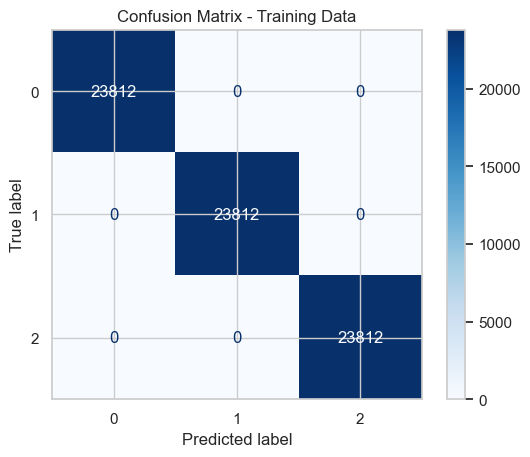

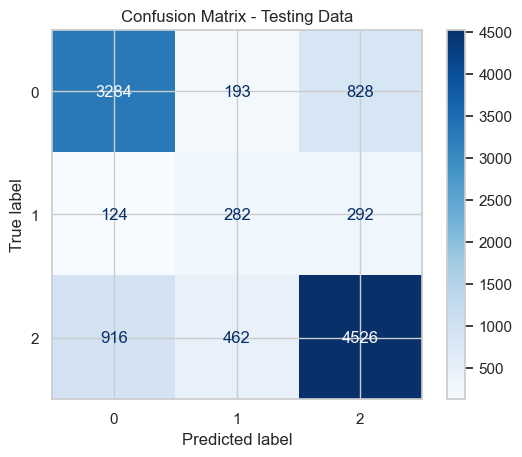

In [116]:
plot_confusion_matrices(tree_clf, X_train_resampled, y_train_resampled, X_test_clean, y_test )

This model is most definitely overfitting as can be seen from the accuracy scores and matrix above.

**Using Hyperparameter tuning for the Decision Tree Classifier**

In [117]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [118]:
# initialise decision tree
dtree = DecisionTreeClassifier(random_state= 42)

grid_search = GridSearchCV(dtree, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'criterion': 'gini', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}


In [119]:
# Instantiate baseline model
best_tree_clf = DecisionTreeClassifier(random_state=42, 
                                       criterion= 'entropy', 
                                       max_depth= 20, 
                                       max_features= 'sqrt', 
                                       min_samples_leaf= 1,
                                       min_samples_split= 10)

# Fit Decision Tree
best_tree_clf.fit(X_train_resampled, y_train_resampled)

DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features='sqrt',
                       min_samples_split=10, random_state=42)

In [120]:
# Predict on the training set
y_hat_train_tree = best_tree_clf.predict(X_train_resampled)

# Predict on the test set
y_hat_test_tree = best_tree_clf.predict(X_test_clean)

# Train accuracy
tree_train_accuracy = accuracy_score(y_train_resampled, y_hat_train_tree) * 100
print('Train accuracy: {:.2f}%'.format(tree_train_accuracy))

# Test accuracy
tree_test_accuracy = accuracy_score(y_test, y_hat_test_tree) * 100
print('Test accuracy: {:.2f}%'.format(tree_test_accuracy))

Train accuracy: 80.05%
Test accuracy: 67.75%


**Evaluating the Tuned Decision Tree Classifier**

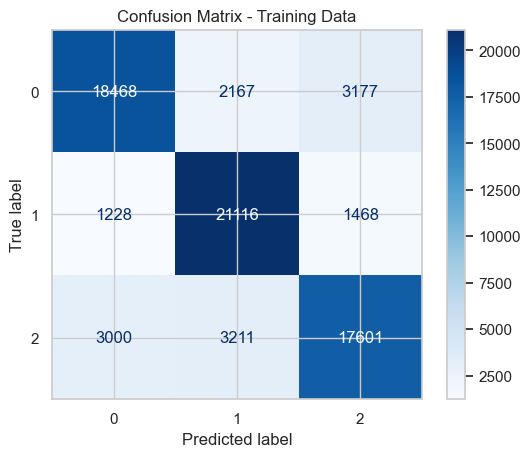

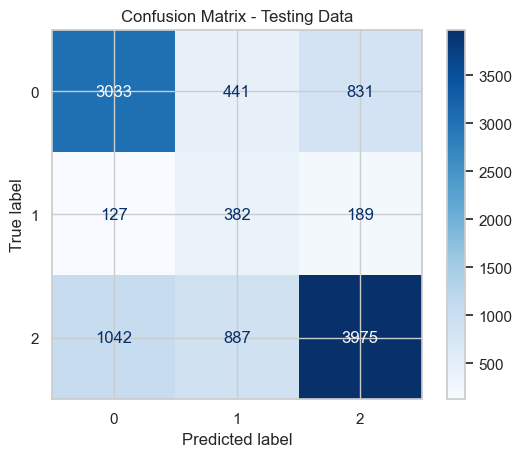

In [121]:
plot_confusion_matrices(best_tree_clf, X_train_resampled, y_train_resampled, X_test_clean, y_test )BB

This model is still overfitting as can be seen from the accuracy scores and matrix above, even after hyperparemeter tuning.

### D. Random Forest Classifier

We're going to specifically avoid any regularization (the default) to see how the model does with little change.

In [122]:
# instantiating RandomForestClassifier
RF = RandomForestClassifier(random_state=42)
# Fitting RandomForestClassifier
RF.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

In [123]:
# Predict on the training set
y_hat_train_RF = RF.predict(X_train_resampled)

# Predict on the test set
y_hat_test_RF = RF.predict(X_test_clean)

# Train accuracy
RF_train_accuracy = accuracy_score(y_train_resampled, y_hat_train_RF) * 100
print('Train accuracy: {:.2f}%'.format(RF_train_accuracy))

# Test accuracy
RF_test_accuracy = accuracy_score(y_test, y_hat_test_RF) * 100
print('Test accuracy: {:.2f}%'.format(RF_test_accuracy))

Train accuracy: 100.00%
Test accuracy: 78.45%


This Random forest baseline model is overfitting the training data so we are going to do a grid search to get the best hyperparameters that would reduce overfitting.

**Using Hyperparameter tuning for the Random Forest Classifier**

In [124]:
param_grid = {
    'max_depth': [ 10, 20],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10]
}

In [125]:
best_RF = RandomForestClassifier()

grid_search = GridSearchCV(best_RF, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_resampled, y_train_resampled)

print("Best parameters found: ", grid_search.best_params_)

Best parameters found:  {'max_depth': 20, 'min_samples_split': 2}


In [126]:
# instantiating RandomForestClassifier
best_RF = RandomForestClassifier(random_state=42, max_depth=20, min_samples_split=2)
# Fitting RandomForestClassifier
best_RF.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=20, random_state=42)

In [127]:
# Predict on the training set
y_hat_train_RF = best_RF.predict(X_train_resampled)

# Predict on the test set
y_hat_test_RF = best_RF.predict(X_test_clean)

# Train accuracy
best_RF_train_accuracy = accuracy_score(y_train_resampled, y_hat_train_RF) * 100
print('Train accuracy: {:.2f}%'.format(best_RF_train_accuracy))

# Test accuracy
best_RF_test_accuracy = accuracy_score(y_test, y_hat_test_RF) * 100
print('Test accuracy: {:.2f}%'.format(best_RF_test_accuracy))

Train accuracy: 93.20%
Test accuracy: 77.22%


**Evaluating the Tuned Random Forest Classifier**

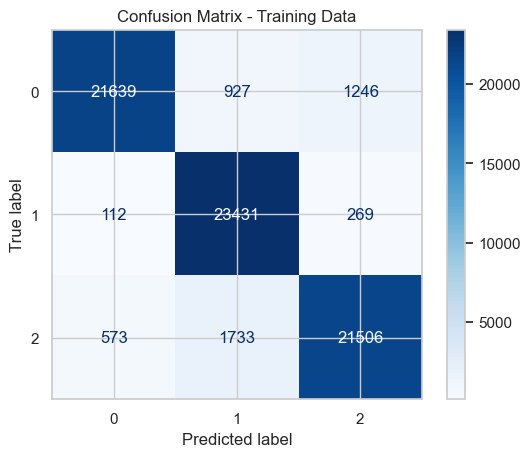

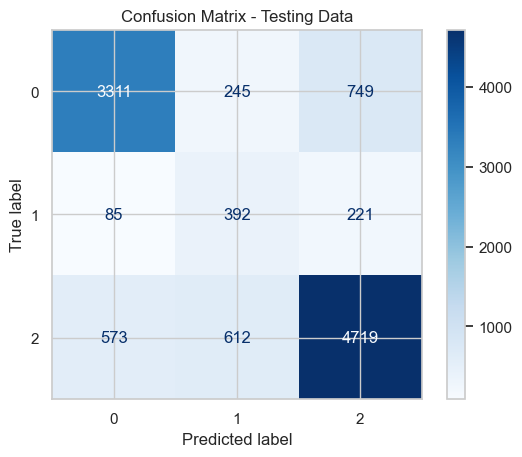

In [128]:
plot_confusion_matrices(best_RF, X_train_resampled, y_train_resampled, X_test_clean, y_test )

The overfitting has reduced but we can still aim for better values. With an accuracy of **77%** on the unseen test data, the Random Forest Classifier does better than the Decision Tree and Baseline Logistic Regression Models

#### Feature importance in Random Forest

In [129]:
best_RF.feature_importances_

array([3.04417303e-02, 5.73239683e-02, 1.04209458e-01, 9.69627616e-02,
       4.46670839e-02, 5.75400050e-02, 1.02632646e-02, 6.27511552e-03,
       4.45258456e-03, 4.67755101e-03, 5.41794412e-03, 4.12579188e-03,
       4.60130476e-03, 4.36862620e-03, 3.74678387e-03, 5.75587007e-04,
       2.94382800e-03, 7.38626258e-03, 1.75633205e-03, 6.74682673e-03,
       2.84733432e-03, 1.16608378e-03, 1.27432304e-03, 1.80792887e-03,
       2.44398507e-03, 2.41476522e-03, 1.35707081e-03, 2.20050952e-03,
       2.18884060e-03, 1.63233942e-03, 1.96915041e-03, 3.30446322e-03,
       1.37841778e-03, 1.42351198e-03, 2.14804342e-03, 2.52379217e-02,
       2.86656591e-03, 1.69275562e-04, 4.44009006e-03, 1.01671076e-02,
       2.49739986e-02, 6.94779726e-04, 1.66690256e-04, 4.99526398e-04,
       7.36077864e-03, 4.29290460e-03, 2.50018921e-04, 1.52100092e-03,
       1.49409501e-04, 2.73170557e-03, 4.34322139e-03, 4.65848694e-04,
       1.07607023e-03, 1.57619944e-02, 2.07186134e-03, 6.32110666e-03,
      

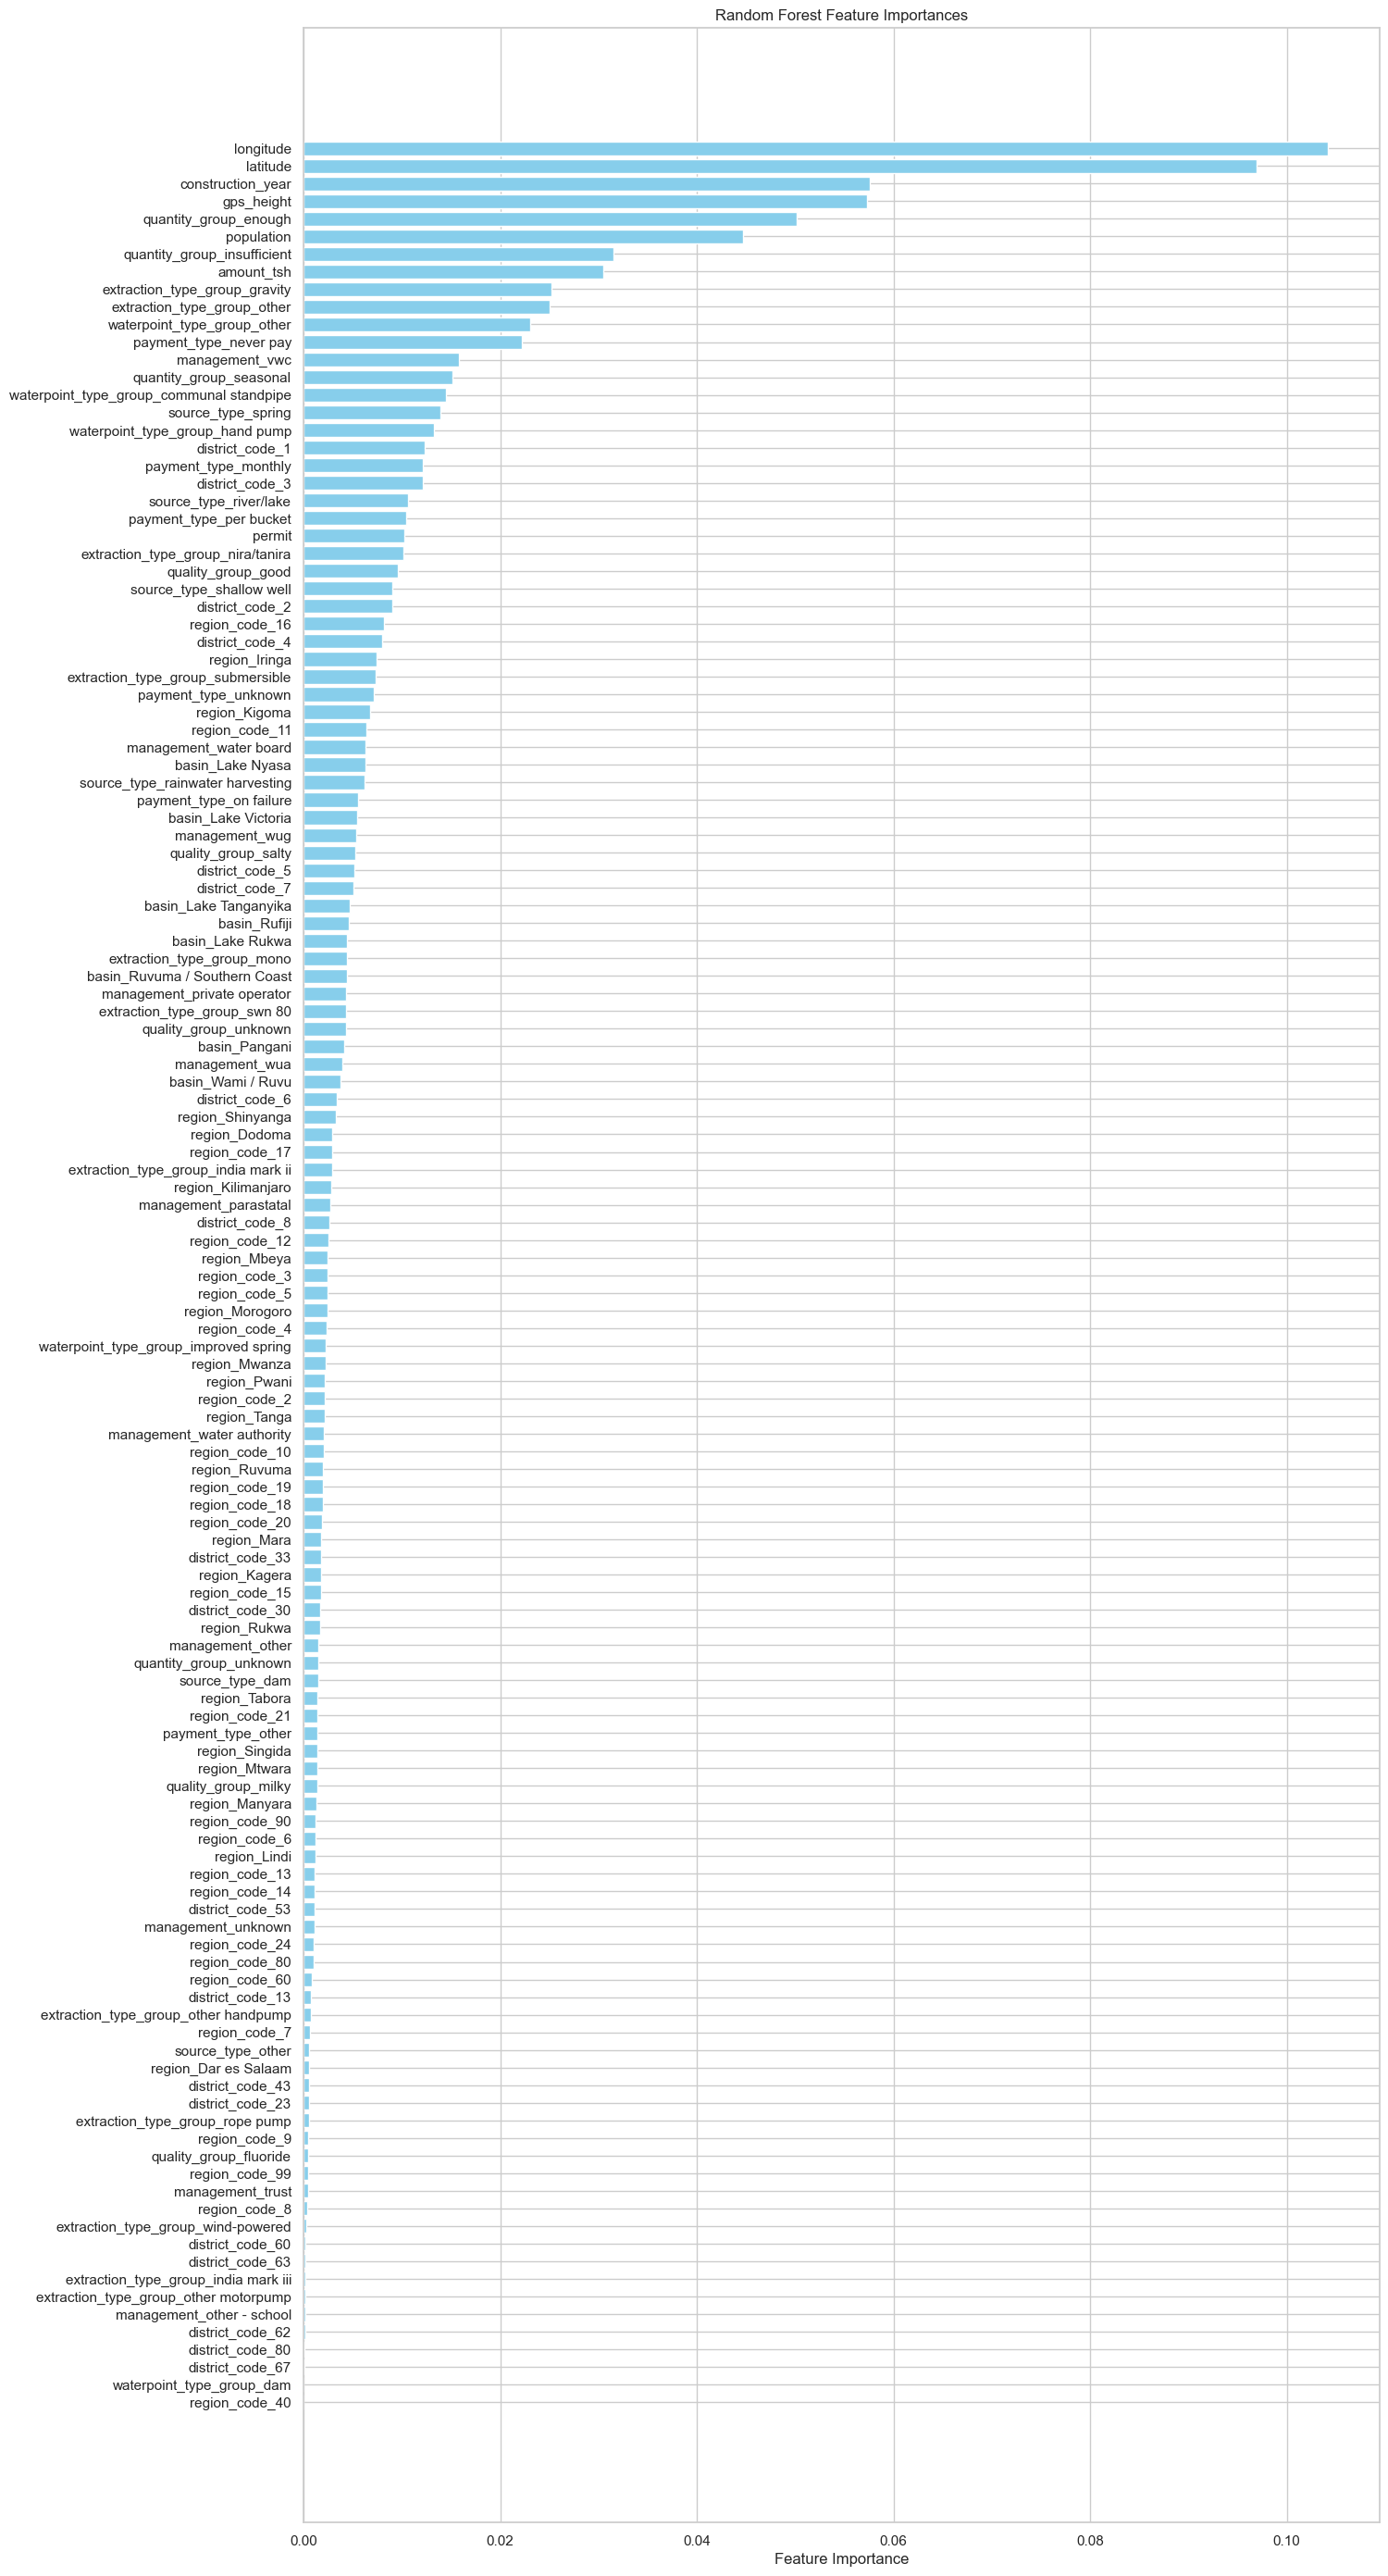

In [130]:
# Assuming best_forest is your trained Random Forest model
sorted_idx = best_RF.feature_importances_.argsort()
feature_importances = best_RF.feature_importances_[sorted_idx]
feature_names = X_train_clean.columns[sorted_idx]

plt.figure(figsize=(15, 35))
plt.barh(range(len(feature_importances)), feature_importances, align='center', color='skyblue')
plt.yticks(range(len(feature_importances)), feature_names)
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importances')

plt.show()

# Model Selection Conclusion

### Rationale

The **Random Forest Classifier** was selected as the top-performing model for this classification task due to its ability to effectively balance complexity and generalization. The model was trained and evaluated on a dataset where the goal was to accurately predict the functional status of waterpoints.

### Results

- **Training Accuracy**: 93.20%
- **Test Accuracy**: 77.22%

These results highlight the model's ability to learn from the training data effectively while still generalizing well to new, unseen data. The 77.22% test accuracy suggests that the model performs well in practical scenarios, meaning it is likely to correctly predict the operational status of a waterpoint about 77% of the time when applied to new data.

### Limitations

Despite the relatively high accuracy, the model's performance shows a noticeable drop from training to test accuracy (from 93.20% to 77.22%), indicating some level of model complexity that may still be capturing noise in the training data. Additionally, a test accuracy of 77.22% implies that there is still a significant proportion (22.78%) of predictions that could be incorrect. This level of accuracy might not be sufficient for critical applications where higher precision is required, such as targeting maintenance resources in regions with severe water scarcity.

Another limitation is that while accuracy is a useful metric, it does not account for potential imbalances in the dataset. For instance, if the dataset has more functional than non-functional waterpoints, accuracy alone may not fully reflect the model's effectiveness in predicting each class equally well. Other evaluation metrics like precision, recall, and the F1-score should be considered for a more comprehensive assessment of the model's performance.


## Recommendations

1. **Refinement of the Model**: Consider further tuning of the Random Forest's hyperparameters, such as the number of trees, depth of trees, and feature selection, to see if slight adjustments can improve test accuracy without increasing overfitting.

2. **Alternative Evaluation Metrics**: Evaluate the model using additional metrics like precision, recall, F1-score, and confusion matrices, especially if the classes are imbalanced. This will provide a better understanding of how well the model distinguishes between functional and non-functional waterpoints.

3. **Ensemble Methods**: Explore other ensemble methods or hybrid models, such as Gradient Boosting or a combination of Random Forest with another model, to see if they can achieve better generalization and higher accuracy.

4. **Data Augmentation**: Consider augmenting the data, especially for underrepresented classes, to help the model learn better and improve its performance on the test set.

5. **Periodic Retraining**: Since the conditions affecting waterpoints can change over time, it's recommended to periodically retrain the model with new data to ensure it remains accurate and relevant in predicting the current status of waterpoints.